In [2]:
%reload_ext autoreload
%autoreload 2
from module_hobin import *

# Applying Agile Model : Y 예측을 위한 ML 분석

In [3]:
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)
raw_all.tail()

datetime  season  holiday  workingday  weather  temp  atemp  \
17374  2012-12-31 19:00       1        0           1        2 10.66  12.88   
17375  2012-12-31 20:00       1        0           1        2 10.66  12.88   
17376  2012-12-31 21:00       1        0           1        1 10.66  12.88   
17377  2012-12-31 22:00       1        0           1        1 10.66  13.63   
17378  2012-12-31 23:00       1        0           1        1 10.66  13.63   

       humidity  windspeed  casual  registered  count  
17374        60      11.00      11         108    119  
17375        60      11.00       8          81     89  
17376        60      11.00       7          83     90  
17377        56       9.00      13          48     61  
17378        65       9.00      12          37     49

## feature engineering

In [4]:
raw_fe = feature_engineering(raw_all)
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)

## data split

In [5]:
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname,'2012-07-01')

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


## lag값 보정

In [6]:
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)

## scaling : normalize

In [7]:
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)

## 다중공선성

In [8]:
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()

Number_of_Total_X:  24
Number_of_Selected_X:  12


In [9]:
fit_reg6 = RandomForestRegressor(n_estimators=100, random_state=123).fit(X_train_feRSM, Y_train_feR)
pred_tr_reg6_feRSM = fit_reg6.predict(X_train_feRSM)
pred_te_reg6_feRSM = fit_reg6.predict(X_test_feRSM)

## random forest로 변수 영향력 확인

In [10]:
fit_reg6.feature_importances_

array([0.0817894 , 0.00109728, 0.46938415, 0.00365062, 0.00308757,
       0.05487622, 0.05235716, 0.15952056, 0.00167149, 0.0226352 ,
       0.03876463, 0.11116572])

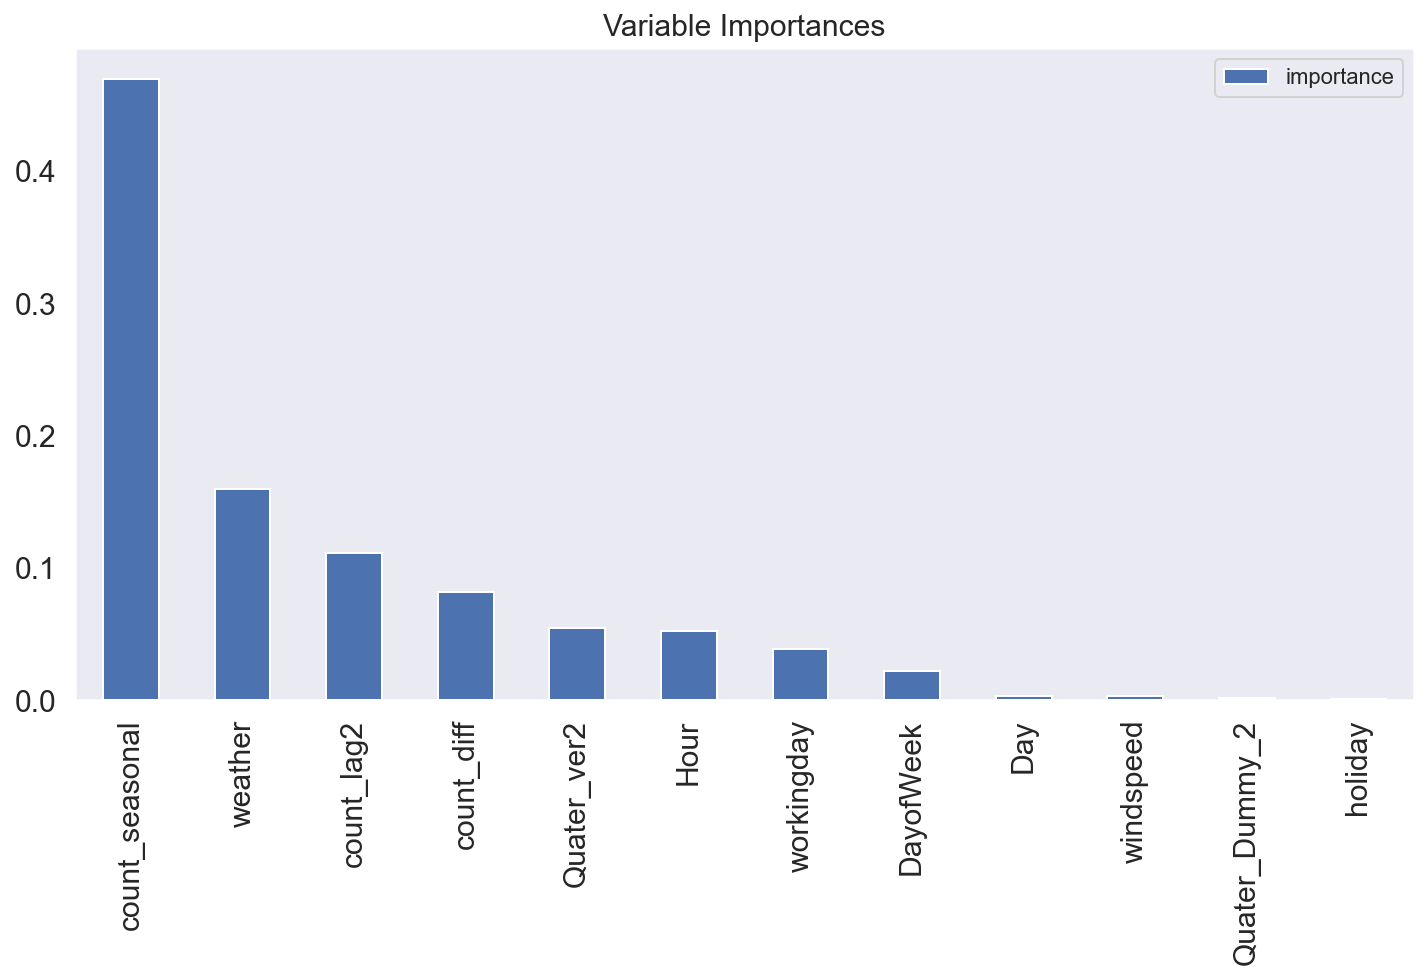

In [11]:
Variable_Importances = pd.DataFrame([fit_reg6.feature_importances_], 
                                    columns=X_train_feRSM.columns, 
                                    index=['importance']).T.sort_values(by=['importance'], ascending=False)
Variable_Importances.plot.bar(figsize=(12,6), fontsize=15)
plt.title('Variable Importances', fontsize=15)
plt.grid()
plt.show()

## evaluation

In [12]:
Score_reg6_feRSM, Resid_tr_reg6_feRSM, Resid_te_reg6_feRSM = evaluation_trte(Y_train_feR,pred_tr_reg6_feRSM,
                                                                   Y_test_feR, pred_te_reg6_feRSM)
display(Score_reg6_feRSM)

MAE      MSE  MAPE
Train  6.54   123.38  9.11
Test  51.52 6,749.92 40.49

In [13]:
Resid_tr_reg6_feRSM

Error
DateTime                  
2011-01-01 00:00:00  -9.93
2011-01-01 01:00:00   5.00
2011-01-01 02:00:00   8.96
2011-01-01 03:00:00  -0.17
2011-01-01 04:00:00  -2.21
...                    ...
2012-06-30 19:00:00  11.20
2012-06-30 20:00:00   8.89
2012-06-30 21:00:00 -14.57
2012-06-30 22:00:00 -13.43
2012-06-30 23:00:00  -1.05

[13128 rows x 1 columns]

## 잔차진단

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

ADF:추세가 어느정도 제거되어 귀무가설(비정상)을 기각합니다.
KPSS:계절성이 어느정도 제거되어 귀무가설(정상) 기각 못합니다.


Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                         -16.29               0.40       0.83   
p-value                                   0.00               0.08       0.00   
Used Lag                                 27.00              41.00        NaN   
Used Observations                    13,100.00                NaN        NaN   
Critical Value(1%)                       -3.43                NaN        NaN   
Maximum Information Criteria         98,935.70                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                       986.72        1,017.92         1,064.70   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                      1,511.67               3.04  
p-value                                  0.00               0.00  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

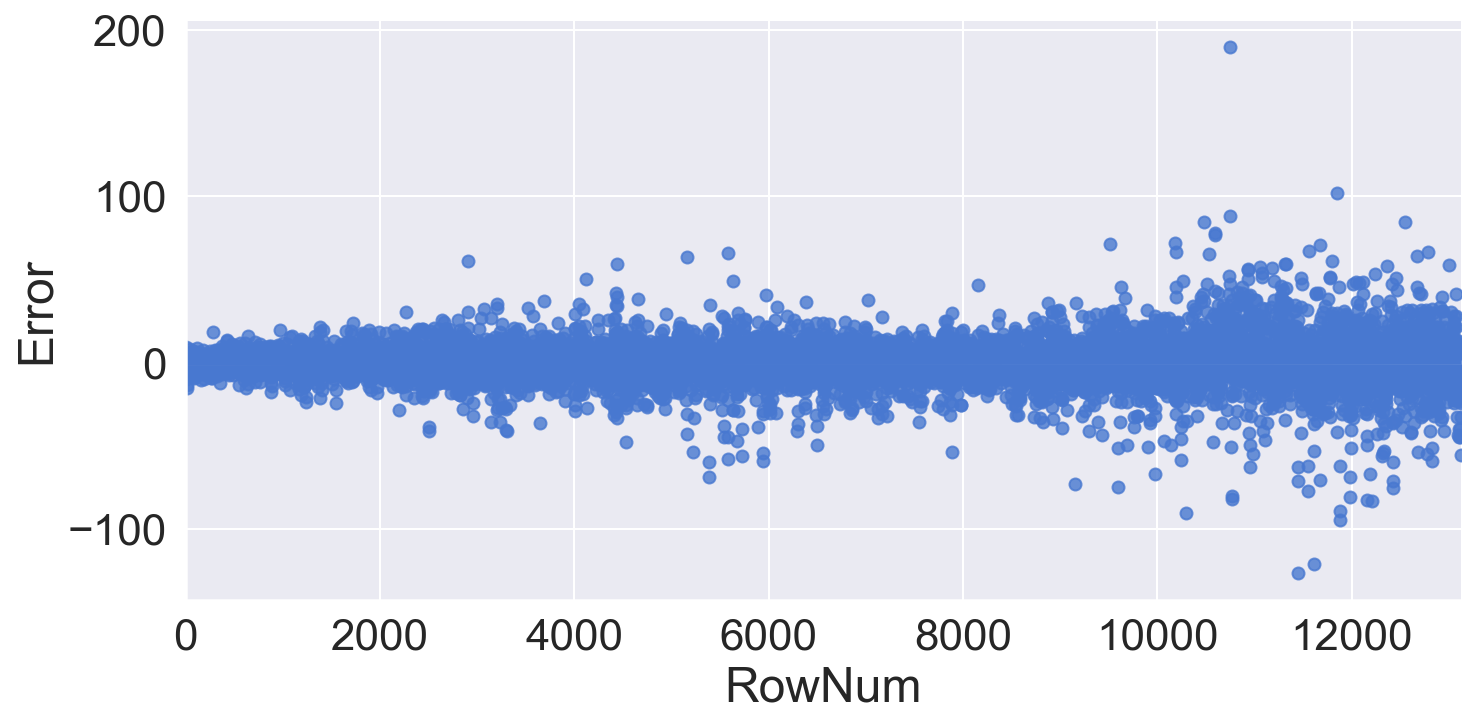

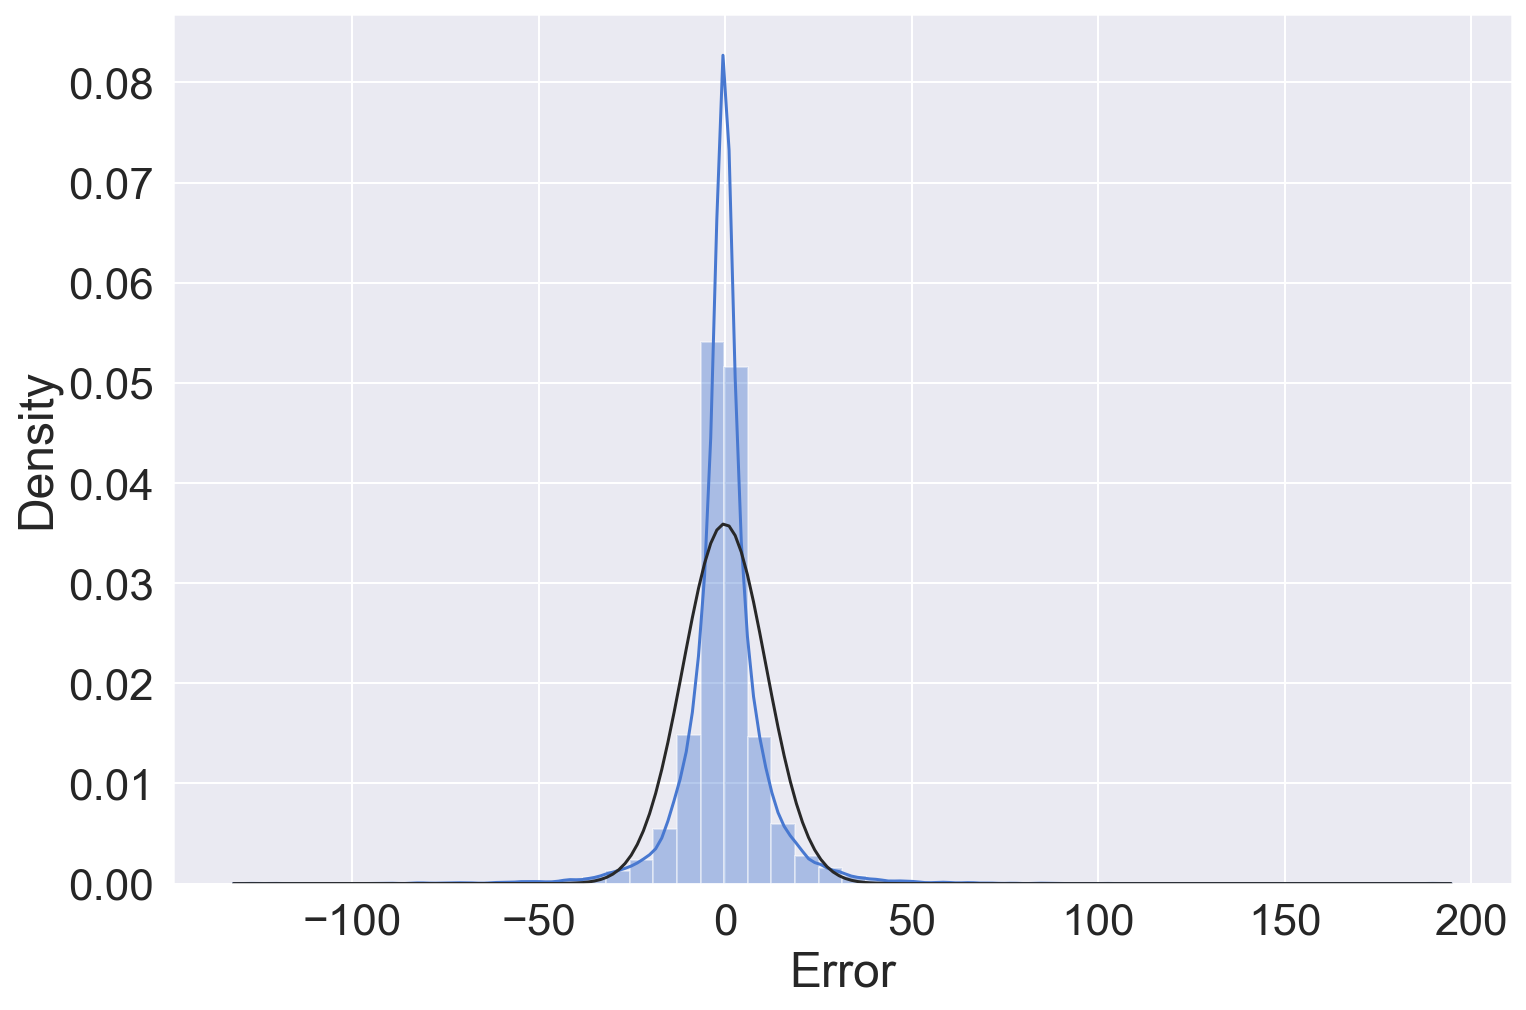

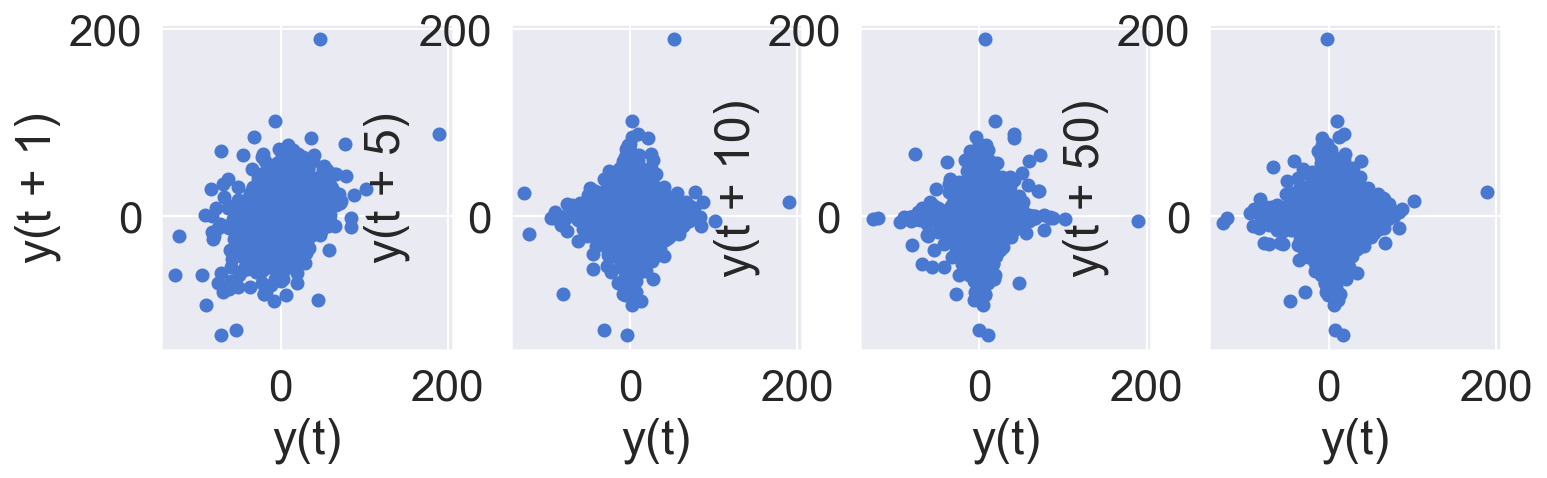

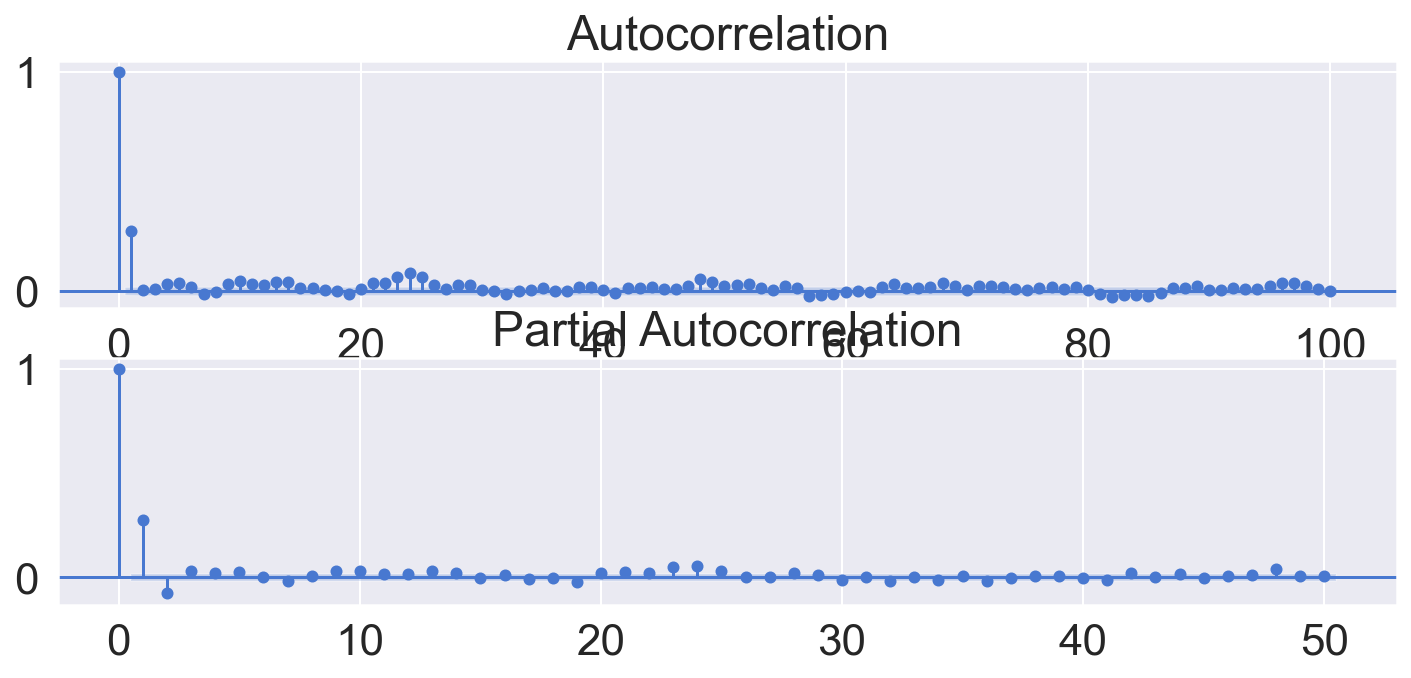

In [14]:
error_analysis(Resid_tr_reg6_feRSM,['Error'], X_train_feRSM, graph_on=True)

# Applying Higher Model : Y예측을 위한 TS분석

In [15]:
result =pd.Series(sm.tsa.stattools.adfuller(Y_train_feR.values.flatten())[0:4],
                 index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
display(result)

Test Statistics         -6.84
p-value                  0.00
Used Lag                41.00
Used Observations   13,086.00
dtype: float64

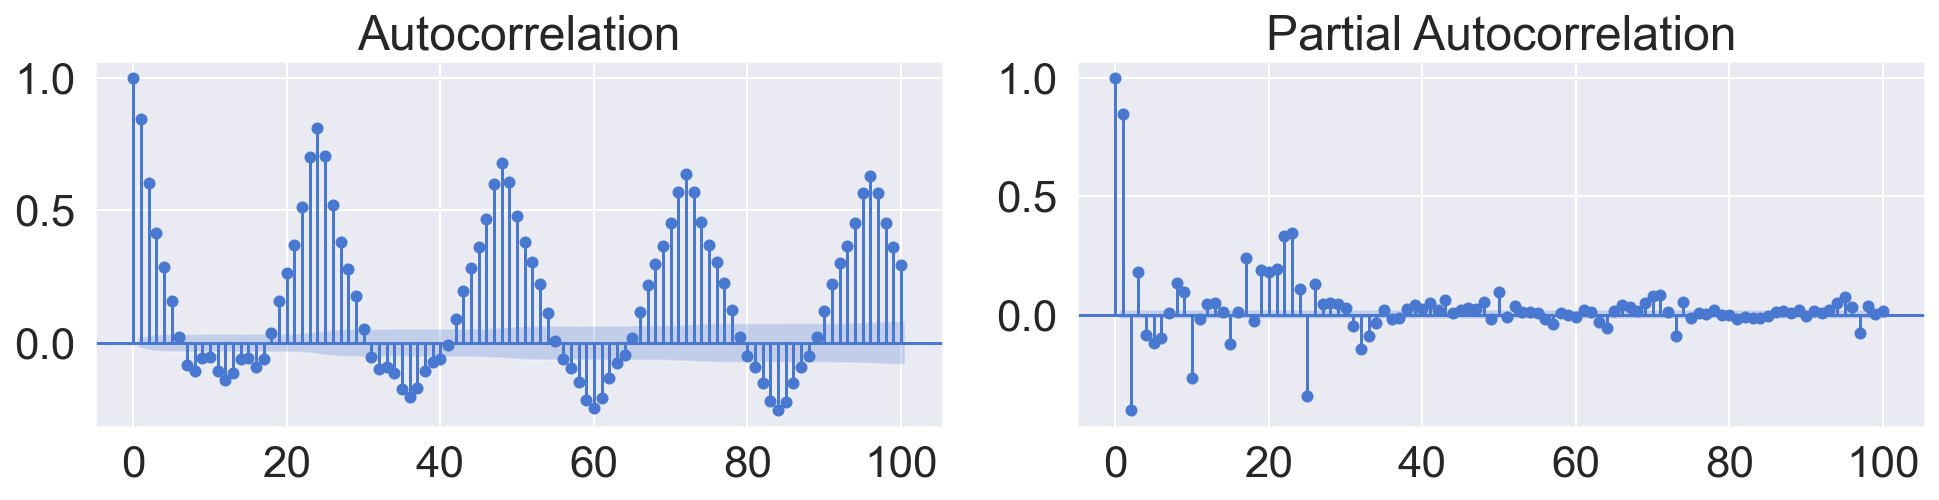

In [16]:
plt.figure(figsize=(14,4))
sm.tsa.graphics.plot_acf(Y_train_feR, lags=100, alpha=0.05, use_vlines=True, ax=plt.subplot(121))
sm.tsa.graphics.plot_pacf(Y_train_feR, lags=100, alpha=0.05, use_vlines=True, ax=plt.subplot(122))
plt.tight_layout()
plt.show()

## 수요예측 SARIMA 모델링

### 정상성 미변환

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


MAE       MSE   MAPE
Train  50.75  4,857.68 162.97
Test  169.07 43,042.13 581.32

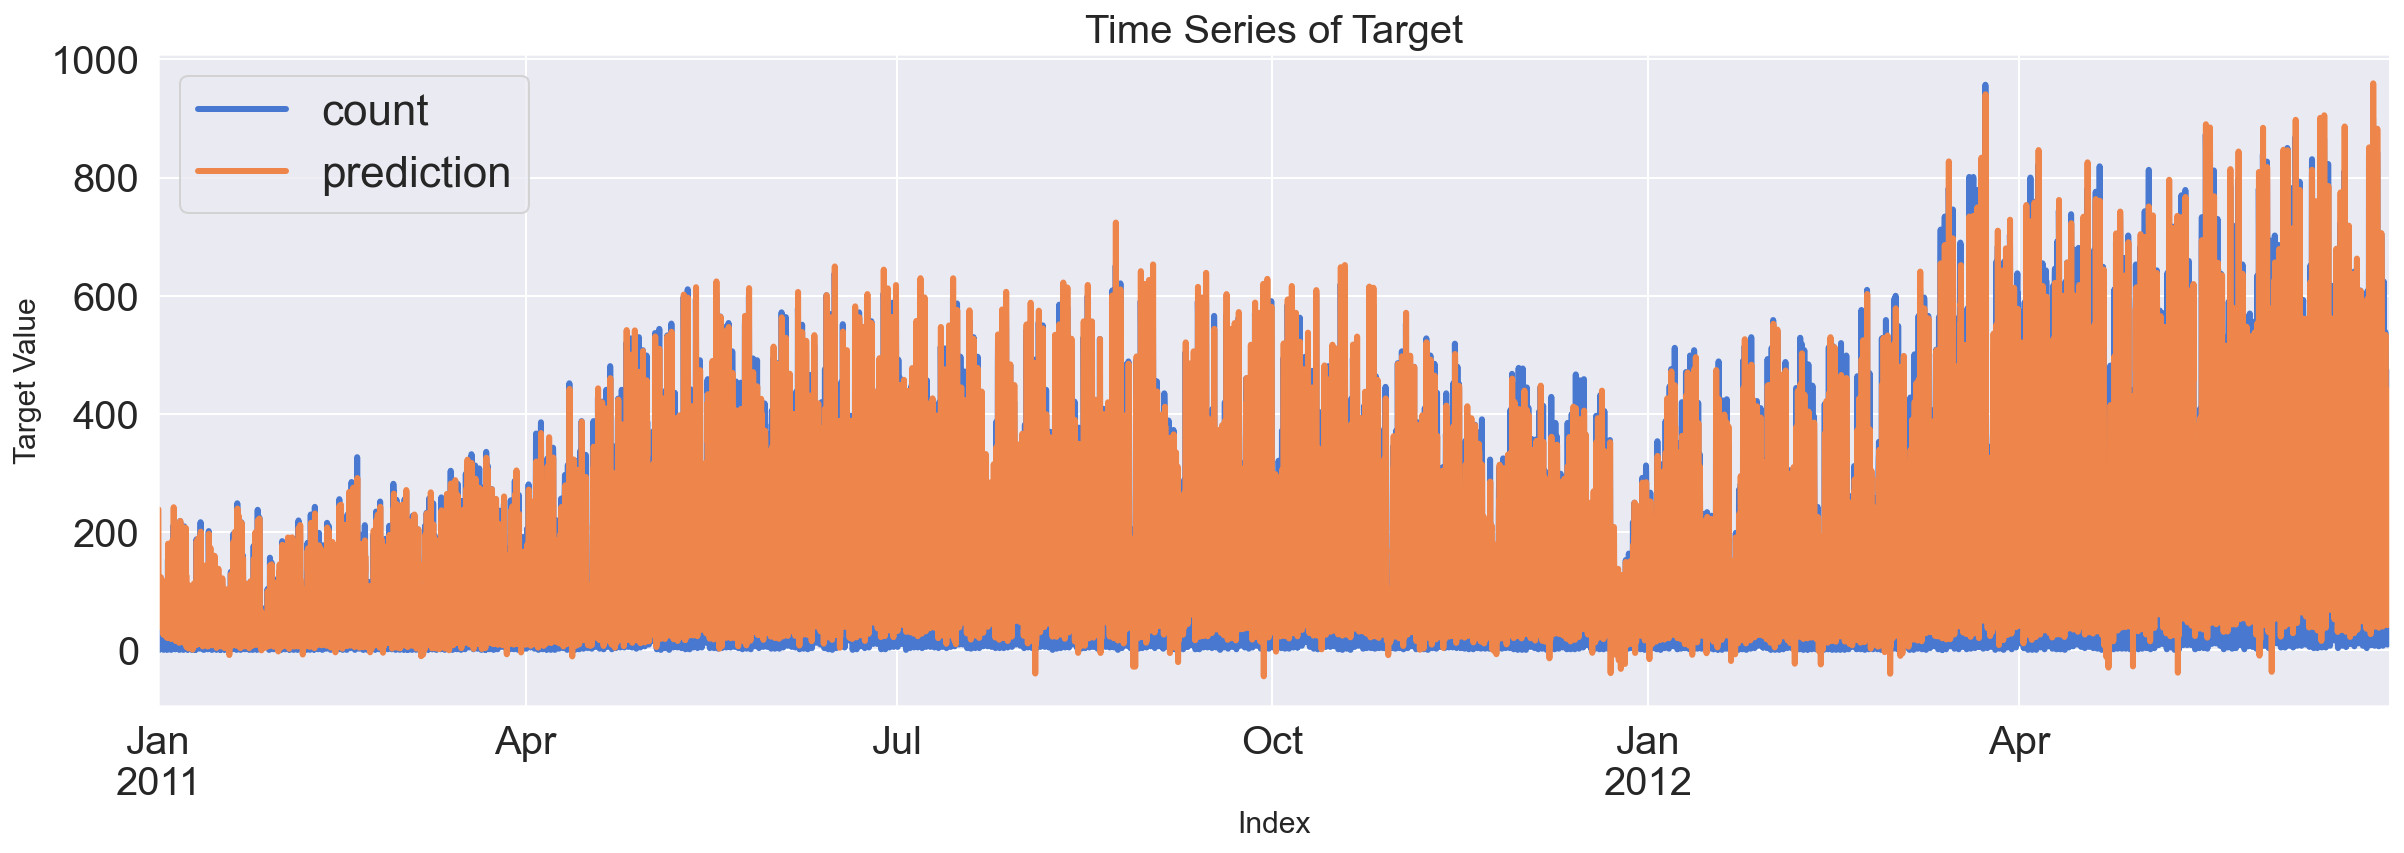

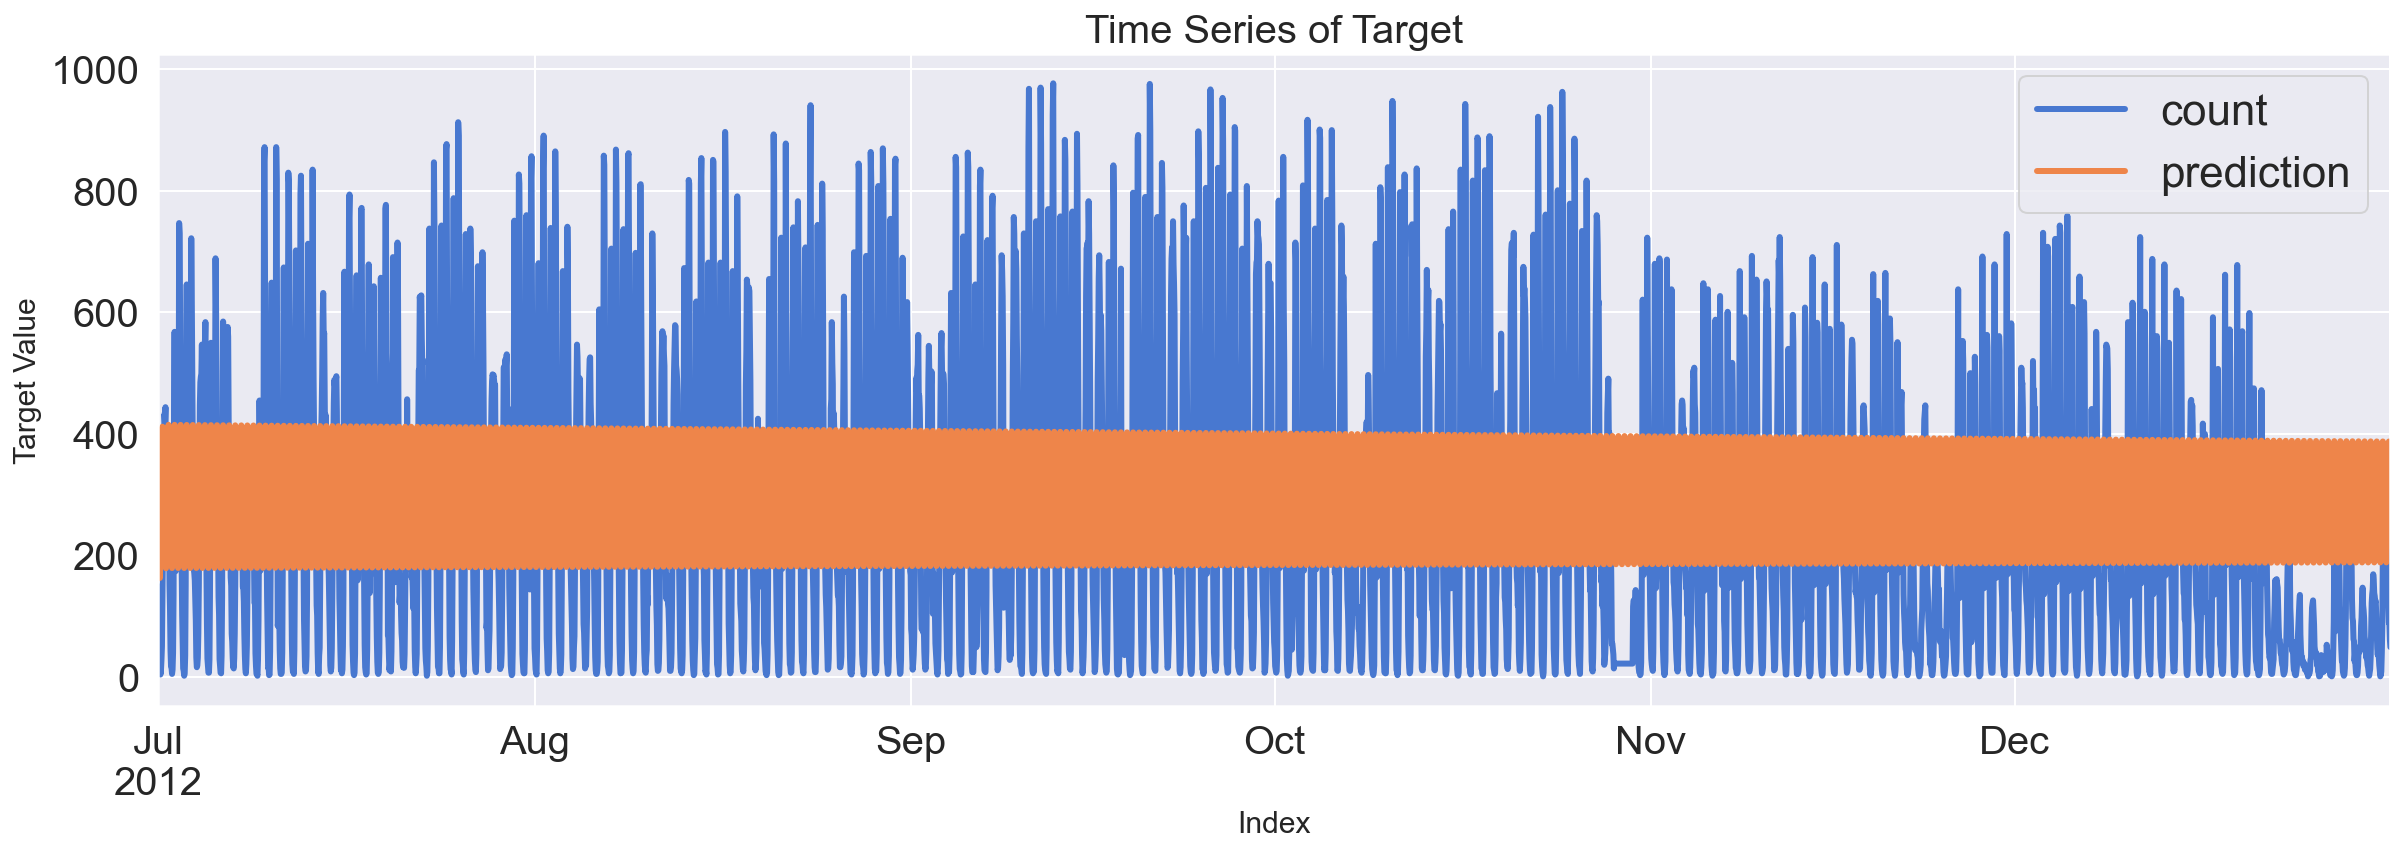

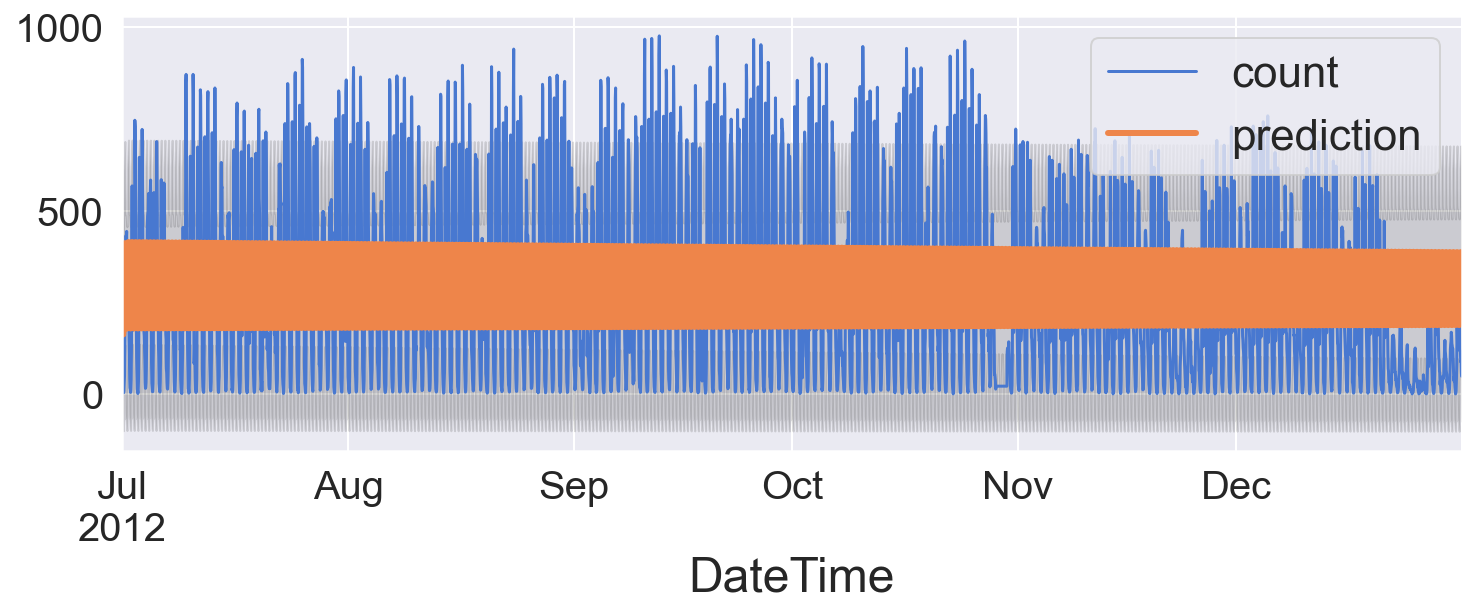

In [17]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

# 모델링
## Parameter Setting
trend_diff_order = 0
seasonal_diff_order, seasonal_order = 0, 12
## SARIMA
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=(1,trend_diff_order,1), 
                                seasonal_order=(1,seasonal_diff_order,1,seasonal_order)).fit()
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_tr_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR)).predicted_mean
pred_te_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR)).conf_int()
    
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

### 정상성 변환 오류

- 비정상 Y -> 정상 $Y_s$
- SARIMAX로 $\hat{Y_s}$ 계산 

- 우리의 원래 타겟은 $Y_s$가 아니라 $Y$이므로 이걸 다시 roll back 해줘야 함

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


MAE  MSE  MAPE
Train 0.43 0.32   inf
Test  1.17 1.90   inf

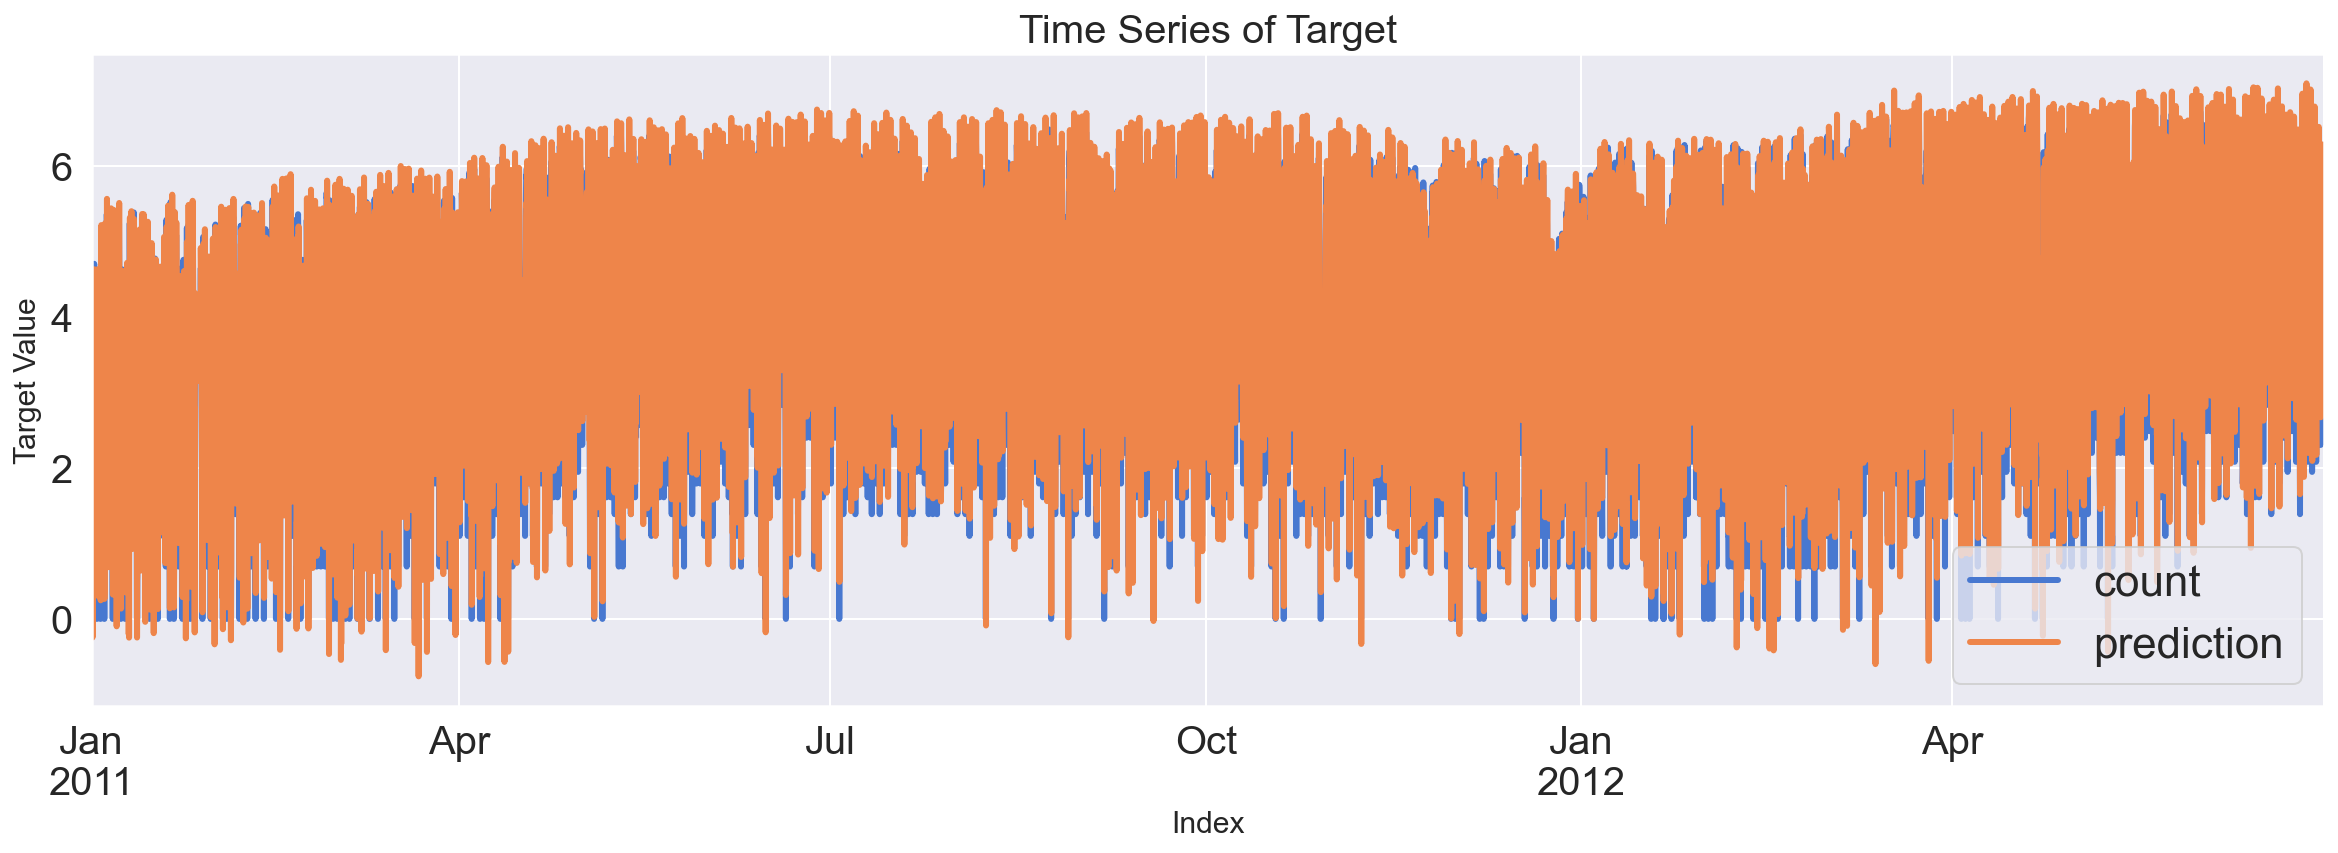

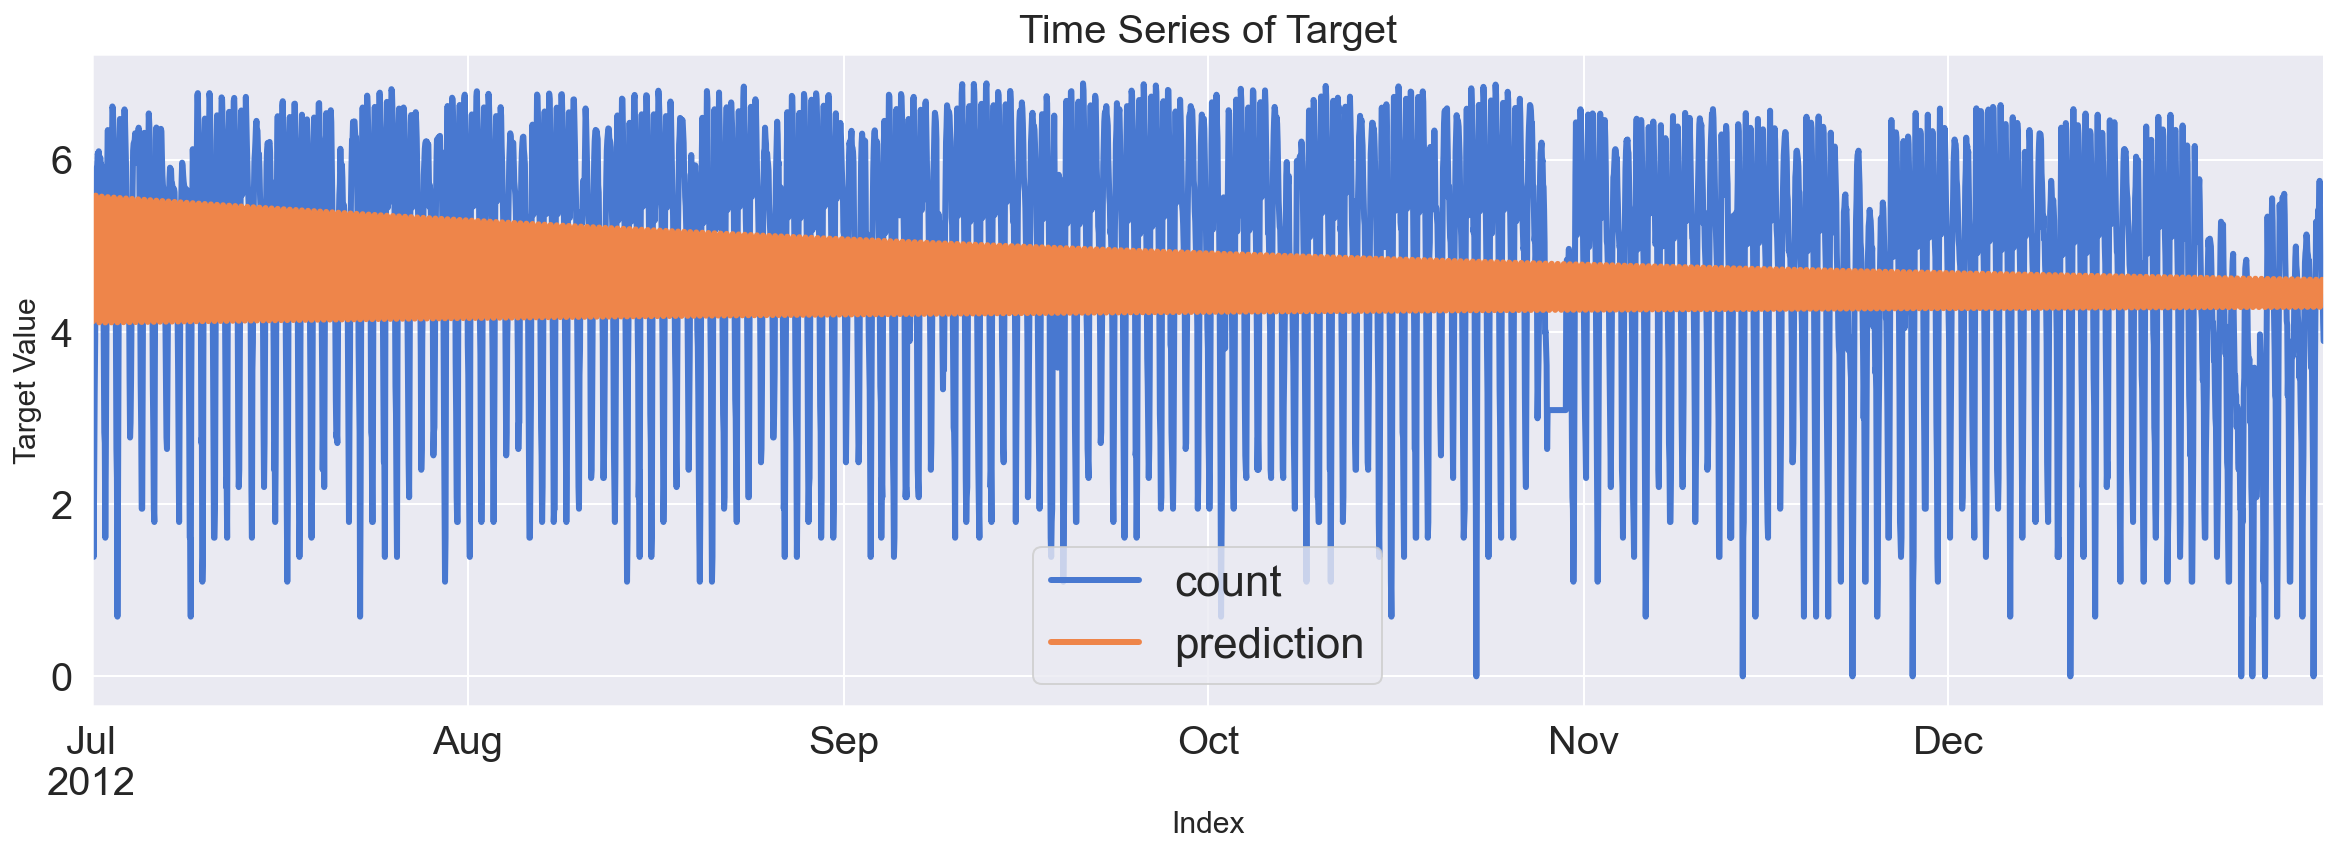

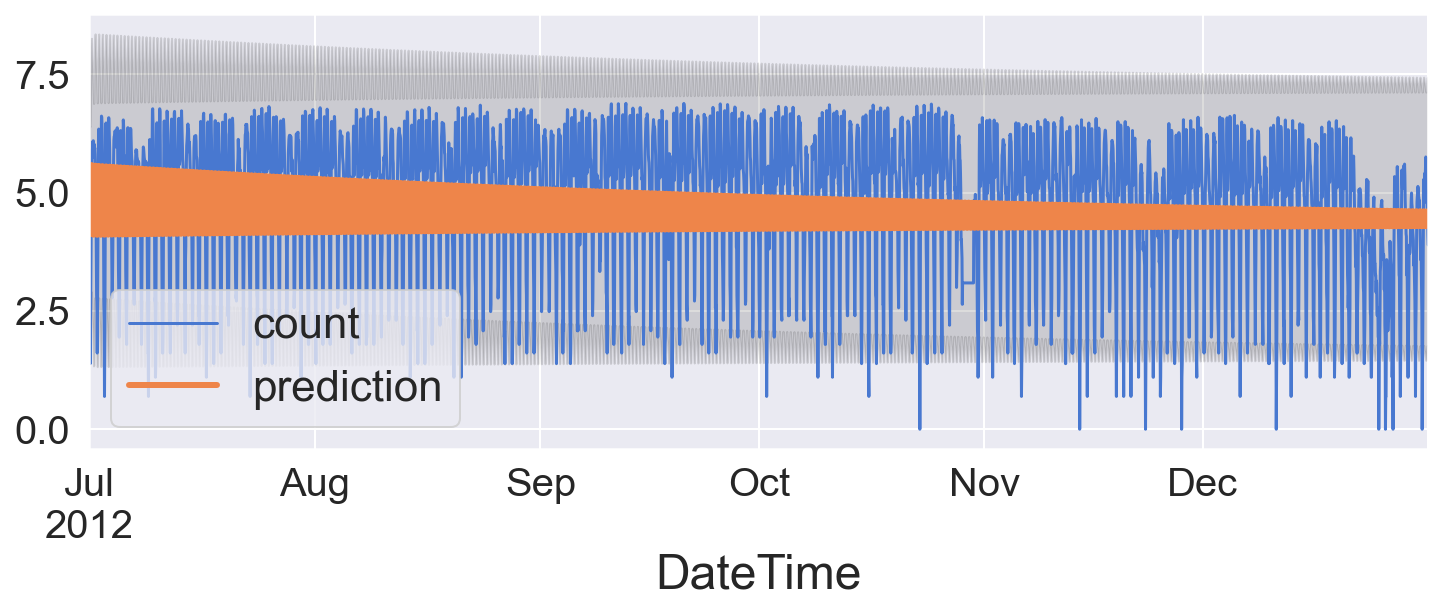

In [18]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

# 모델링
## Parameter Setting
logarithm = True
trend_diff_order = 0
seasonal_diff_order, seasonal_order = 0, 12
## 비정상성 데이터의 정상성 변환
if logarithm:
    Y_train_feR = np.log(Y_train_feR).copy()
    Y_test_feR = np.log(Y_test_feR).copy()
##############################
## SARIMA
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=(1,trend_diff_order,1), 
                                seasonal_order=(1,seasonal_diff_order,1,seasonal_order)).fit()
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_tr_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR)).predicted_mean
pred_te_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR)).conf_int()
    
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

### 정상성 변환 및 복원

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


MAE       MSE   MAPE
Train  51.74  6,004.03  51.27
Test  184.11 66,843.60 213.87

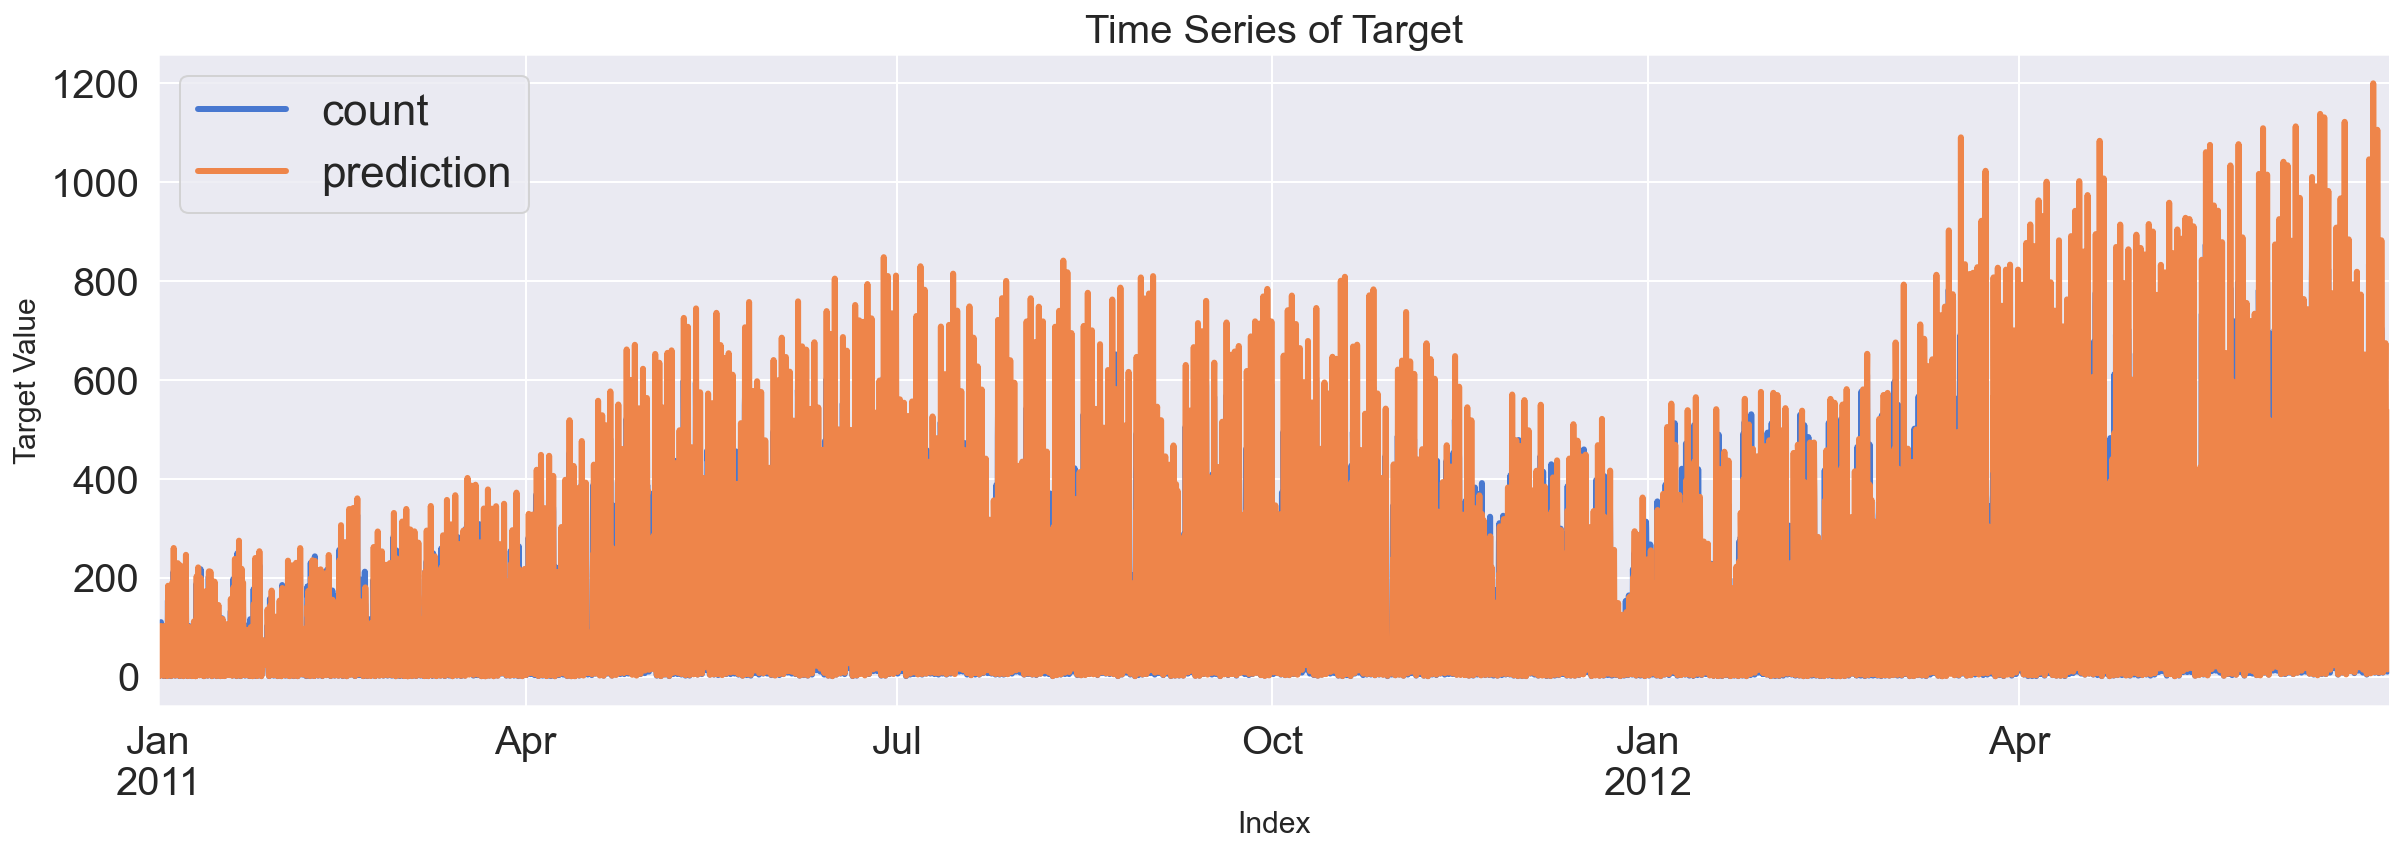

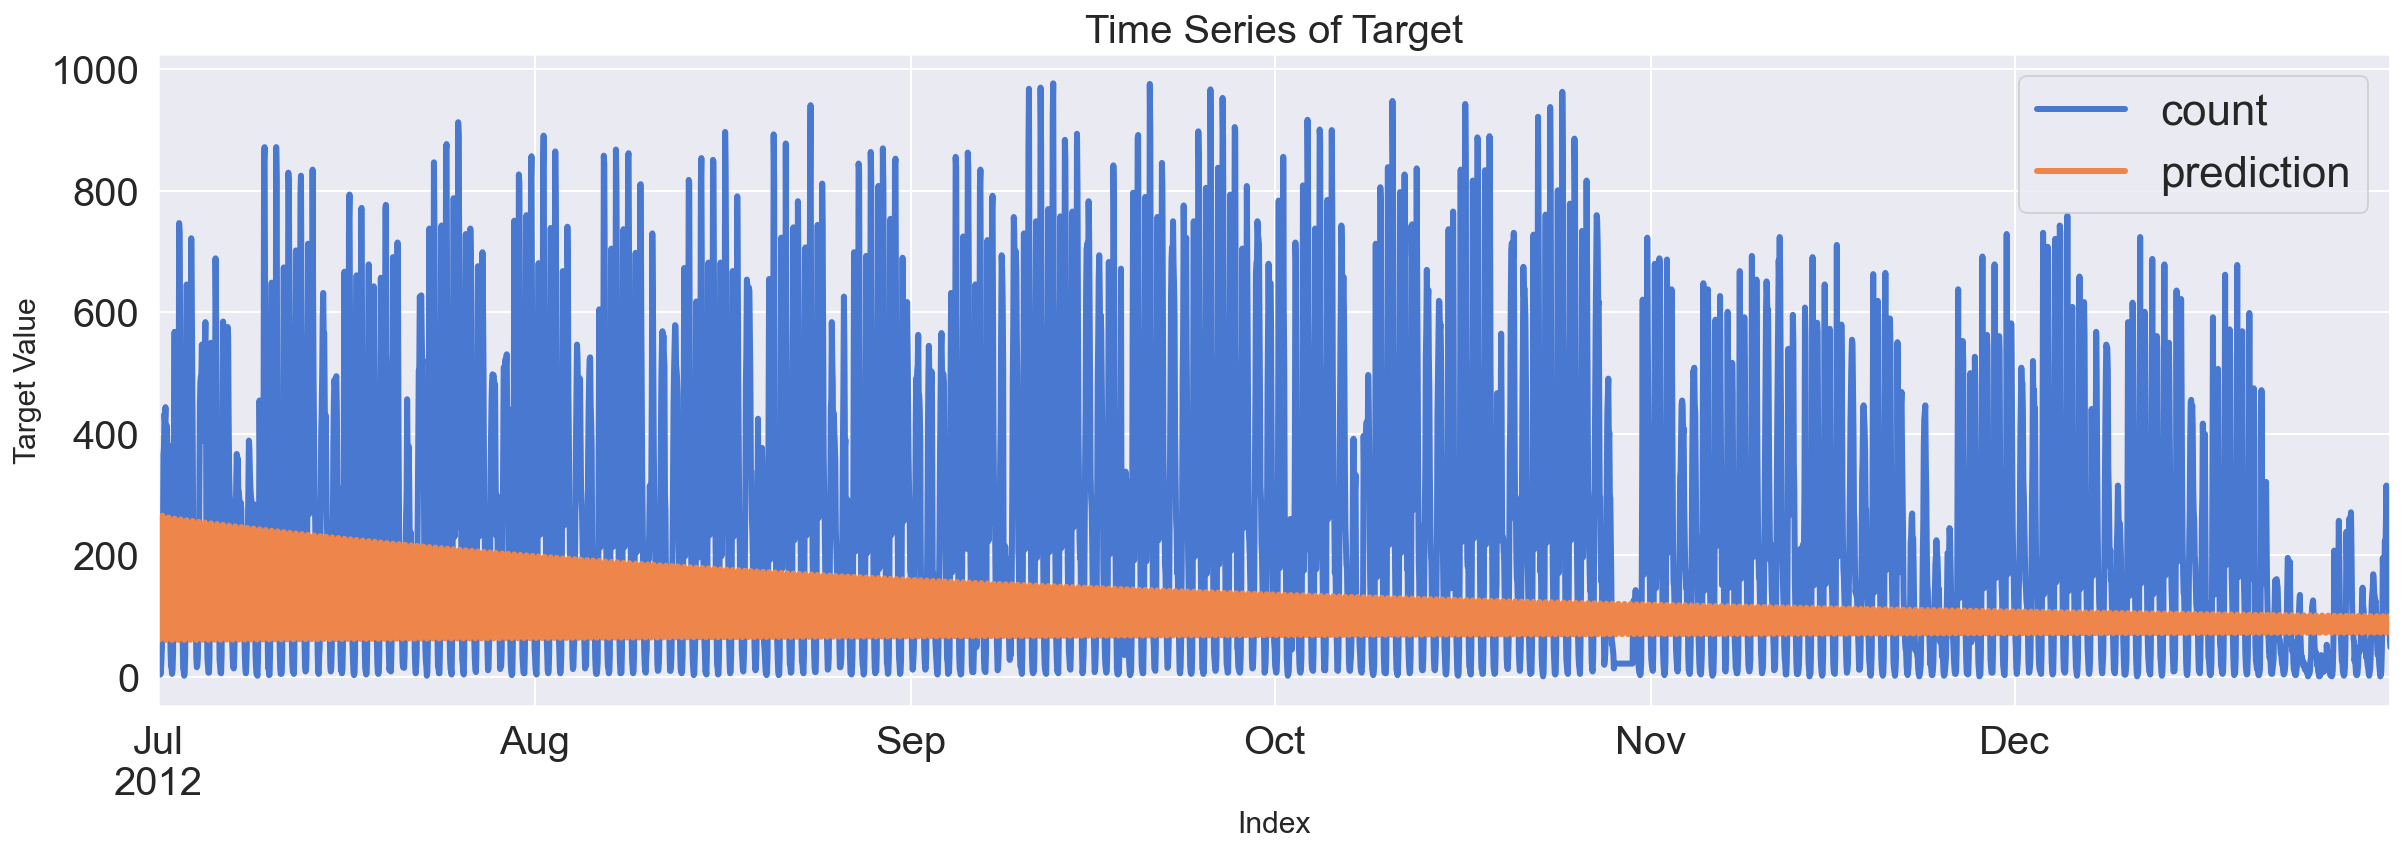

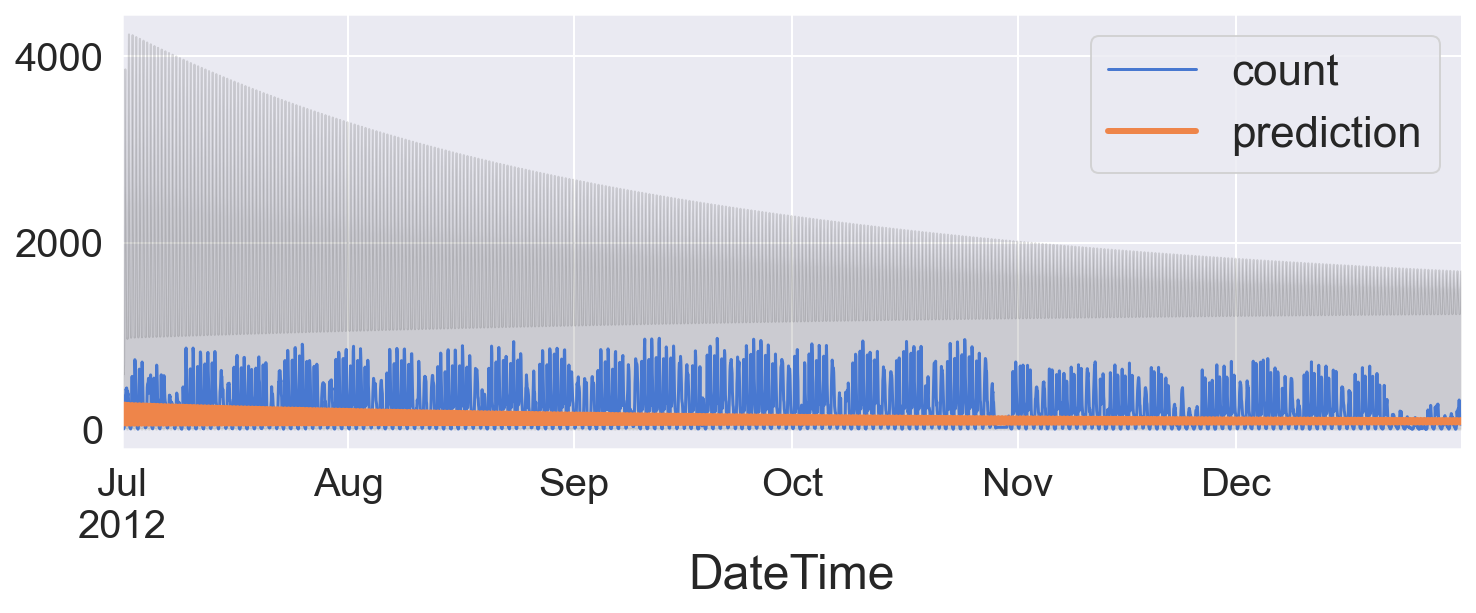

In [19]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

# 모델링
## Parameter Setting
logarithm = True
trend_diff_order = 0
seasonal_diff_order, seasonal_order = 0, 12
## 비정상성 데이터의 정상성 변환
if logarithm:
    Y_train_feR = np.log(Y_train_feR).copy()
    Y_test_feR = np.log(Y_test_feR).copy()
##############################
## SARIMA
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=(1,trend_diff_order,1), 
                                seasonal_order=(1,seasonal_diff_order,1,seasonal_order)).fit()
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_tr_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR)).predicted_mean
pred_te_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR)).conf_int()
## 정상성 데이터의 비정상성 변환
if logarithm:
    Y_train_feR = np.exp(Y_train_feR).copy()
    Y_test_feR = np.exp(Y_test_feR).copy()
    pred_tr_ts_sarimax = np.exp(pred_tr_ts_sarimax).copy()
    pred_te_ts_sarimax = np.exp(pred_te_ts_sarimax).copy()
    pred_te_ts_sarimax_ci = np.exp(pred_te_ts_sarimax_ci).copy()
##############################
    
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

### 요약

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              count   No. Observations:                13128
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood              -74352.628
Date:                            Wed, 23 Jun 2021   AIC                         148717.255
Time:                                    17:25:45   BIC                         148762.150
Sample:                                01-01-2011   HQIC                        148732.249
                                     - 06-30-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0309      0.017      1.810      0.070      -0.003       0.064
ar.L1          0.7213      0.006    130.830      0.000       0.711       0.732
ma.L1          0.5025      0.008     65.047      0.000       0.487       0.518
ar.S.L12       0.9995      0.000   3902.902      0.000       0.999       1.000
ma.S.L12      -0.9834      0.001   -657.637      0.000      -0.986      -0.980
sigma2      4873.8821     47.535    102.533      0.000    4780.716    4967.049
===================================================================================
Ljung-Box (L1) (Q):                  30.91   Jarque-Bera (JB):              3766.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.55   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAE       MSE   MAPE
Train  50.75  4,857.68 162.97
Test  169.07 43,042.13 581.32

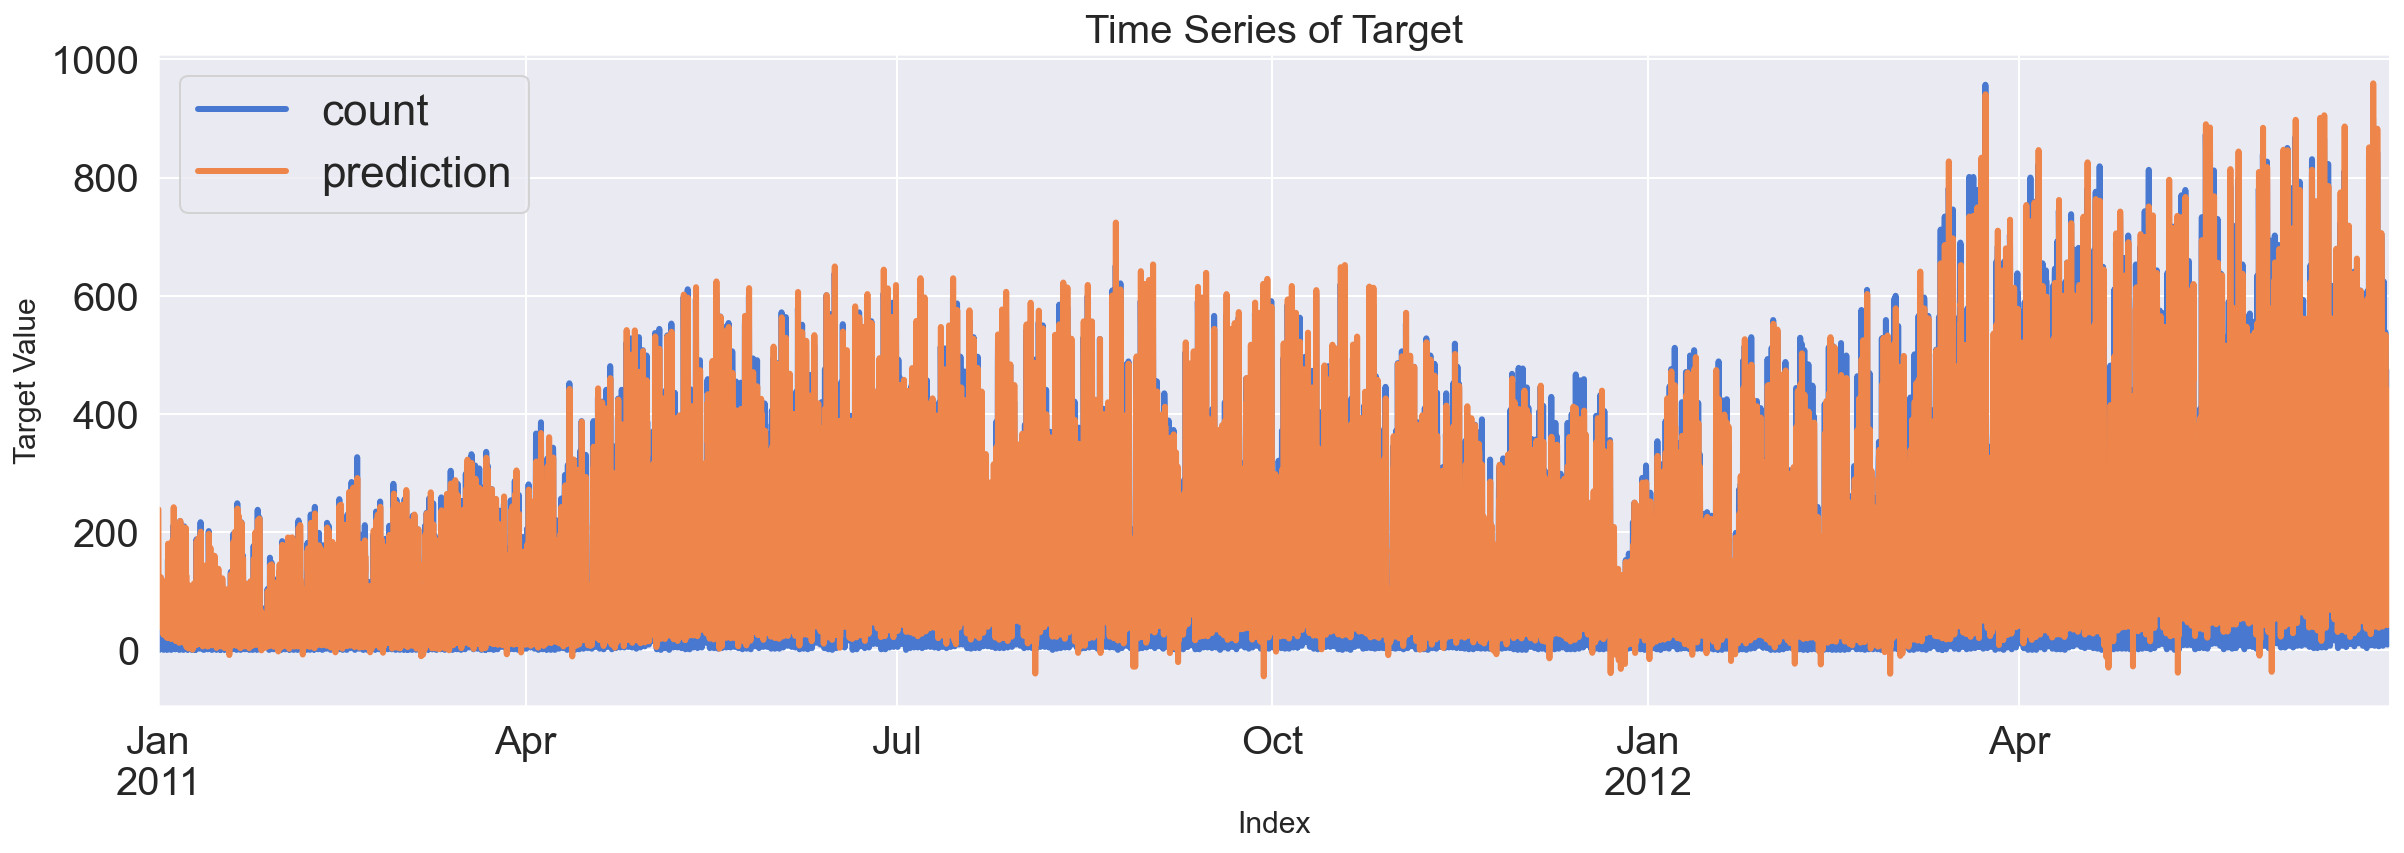

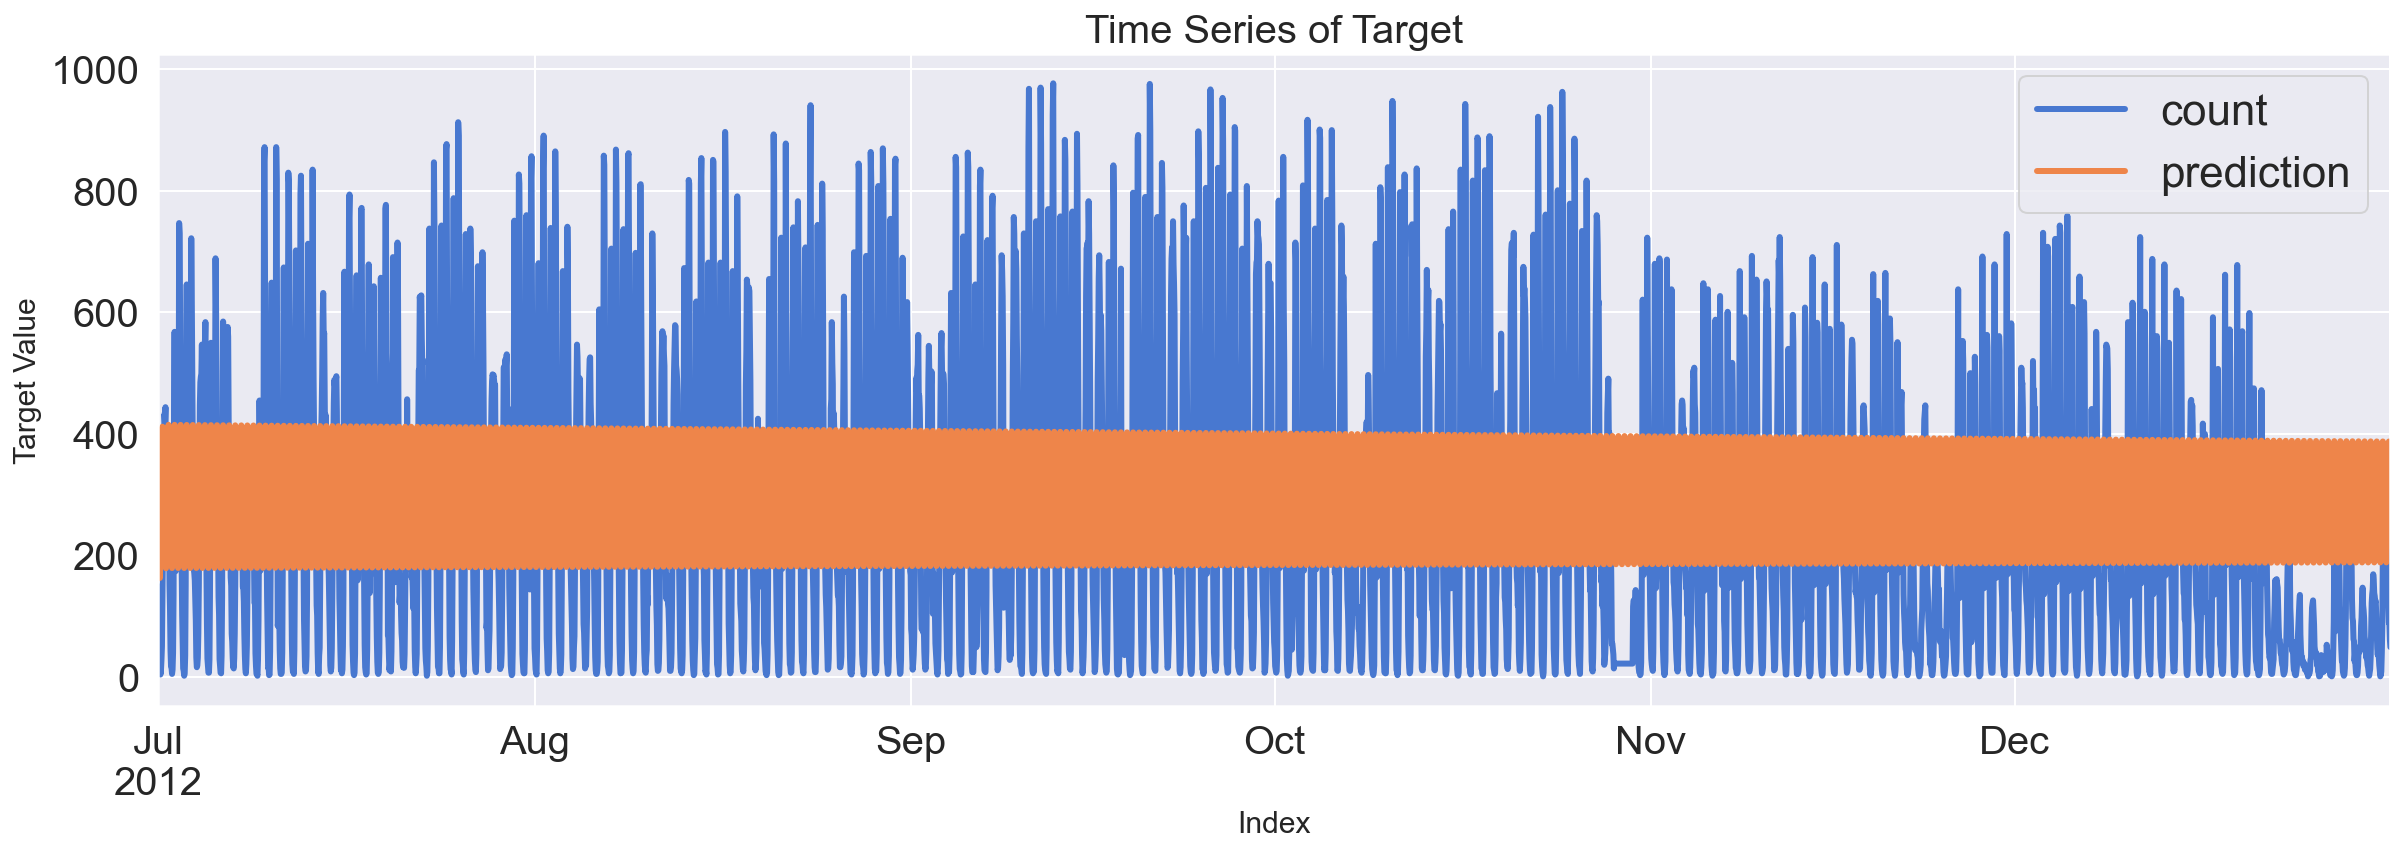

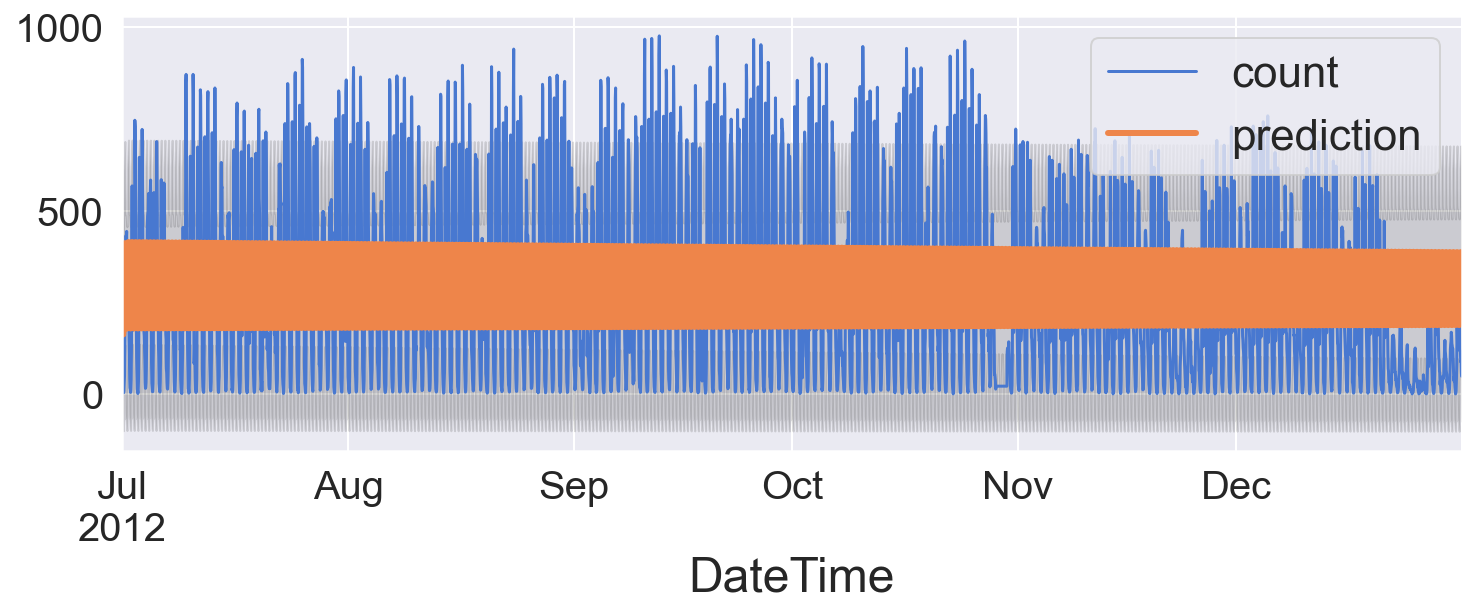

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

ADF:추세가 어느정도 제거되어 귀무가설(비정상)을 기각합니다.
KPSS:계절성이 어느정도 남아있어 귀무가설(정상)을 기각합니다.


Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                         -14.45               1.13       0.96   
p-value                                   0.00               0.01       0.00   
Used Lag                                 40.00              41.00        NaN   
Used Observations                    13,087.00                NaN        NaN   
Critical Value(1%)                       -3.43                NaN        NaN   
Maximum Information Criteria        139,509.19                NaN        NaN   
Critical Value(10%)                        NaN               0.35        NaN   
Alternative                                NaN                NaN        NaN   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                        30.95          576.02         1,990.37   
p-value                                 0.00            0.00             0.00   
Used Lag                                 NaN             NaN              NaN   
Used Observations                        NaN             NaN              NaN   
Critical Value(1%)                       NaN             NaN              NaN   
Maximum Information Criteria             NaN             NaN              NaN   
Critical Value(10%)                      NaN             NaN              NaN   
Alternative                              NaN             NaN              NaN   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                     17,394.51               1.70  
p-value                                  0.00               0.00  
Used Lag                                  NaN                NaN  
Used Observations                         NaN                NaN  
Critical Value(1%)                        NaN                NaN  
Maximum Information Criteria              NaN                NaN  
Critical Value(10%)                       NaN                NaN  
Alternative                               NaN          two-sided

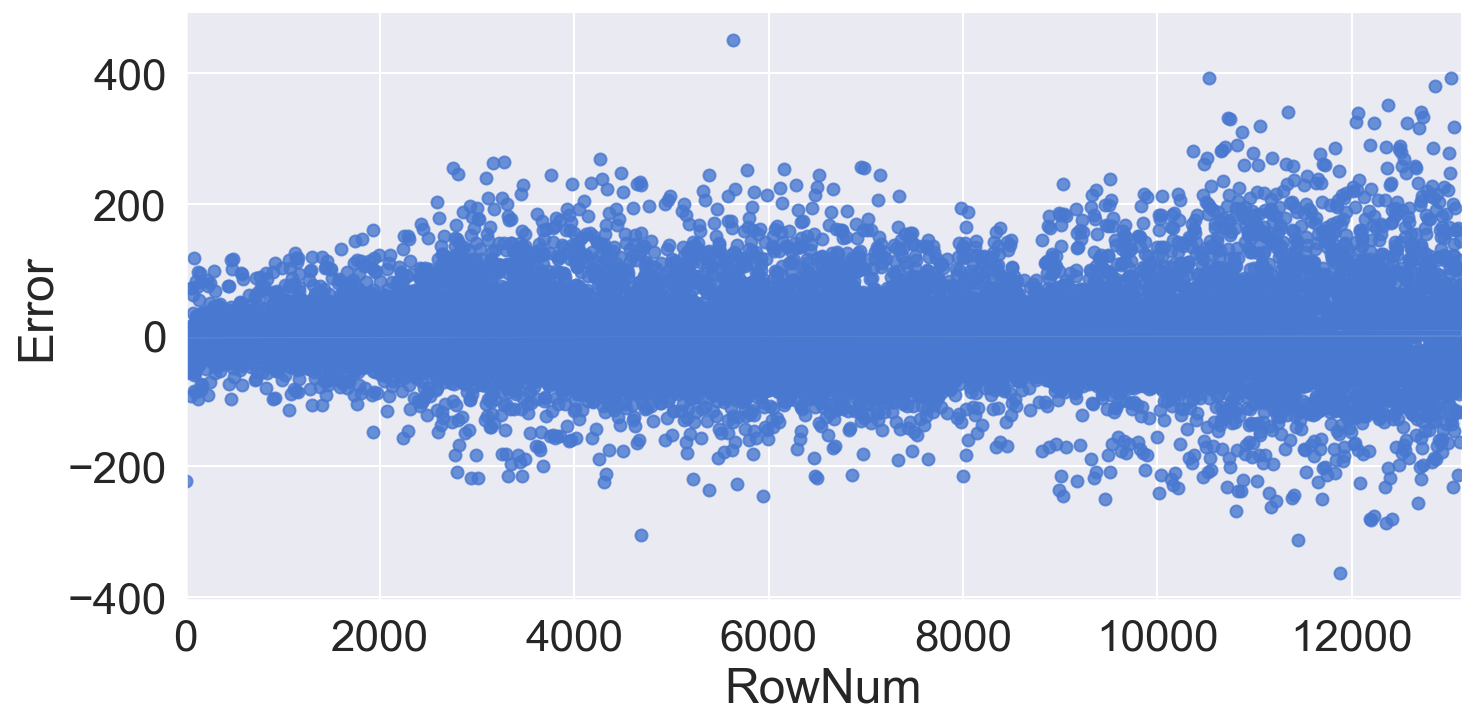

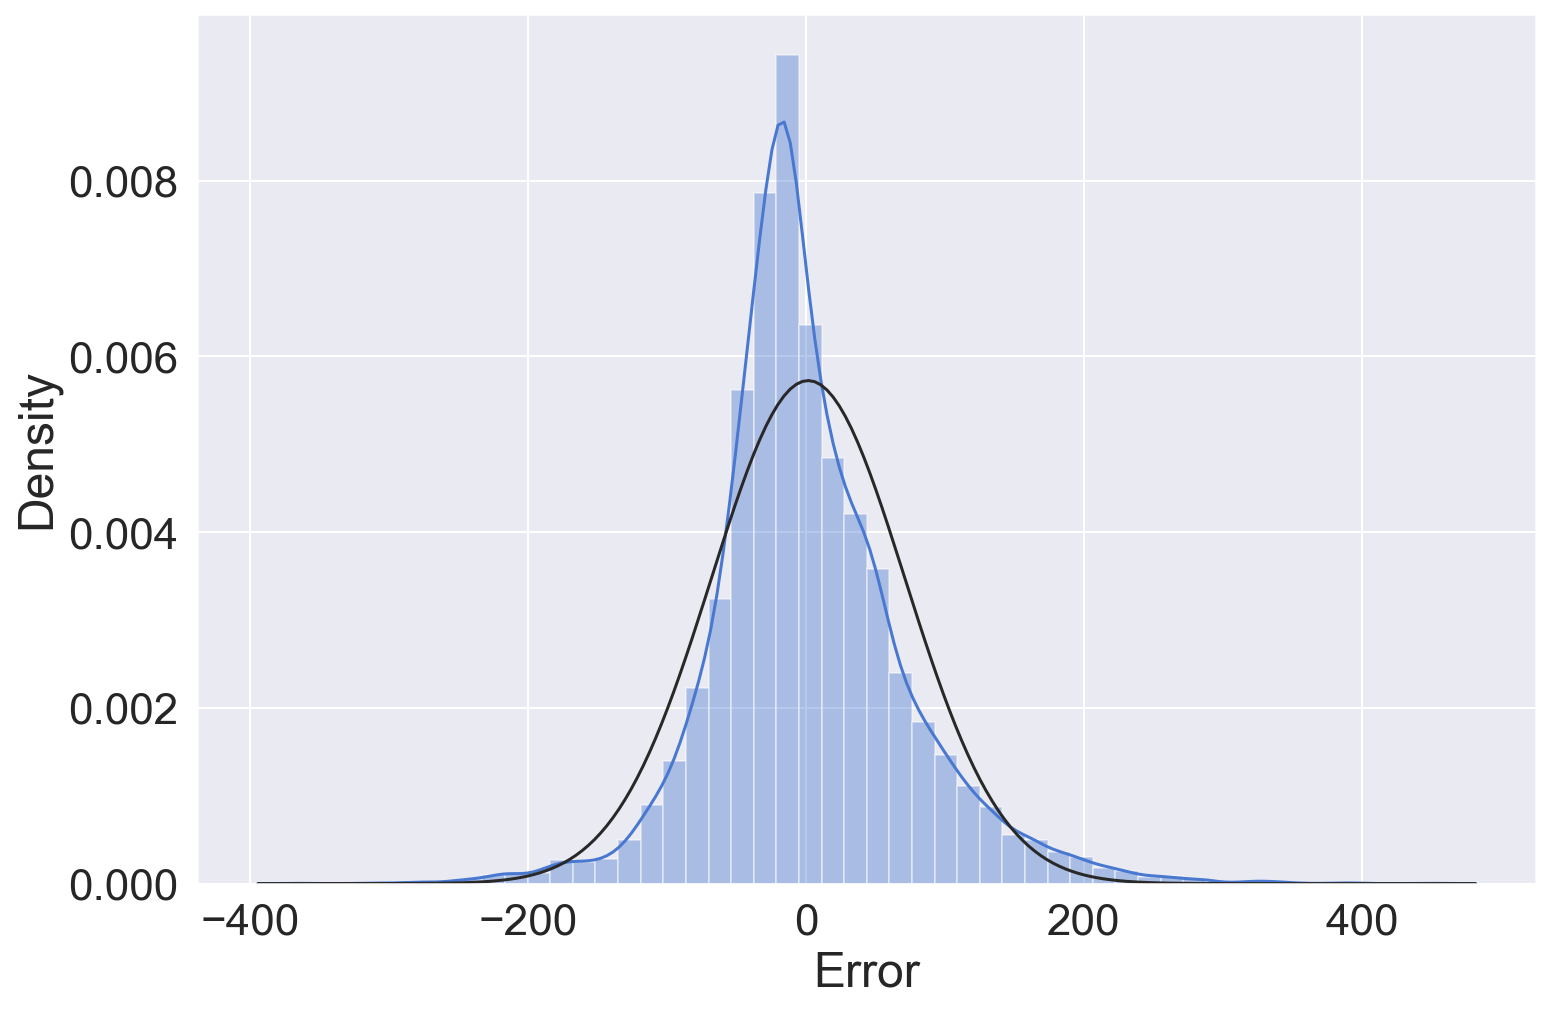

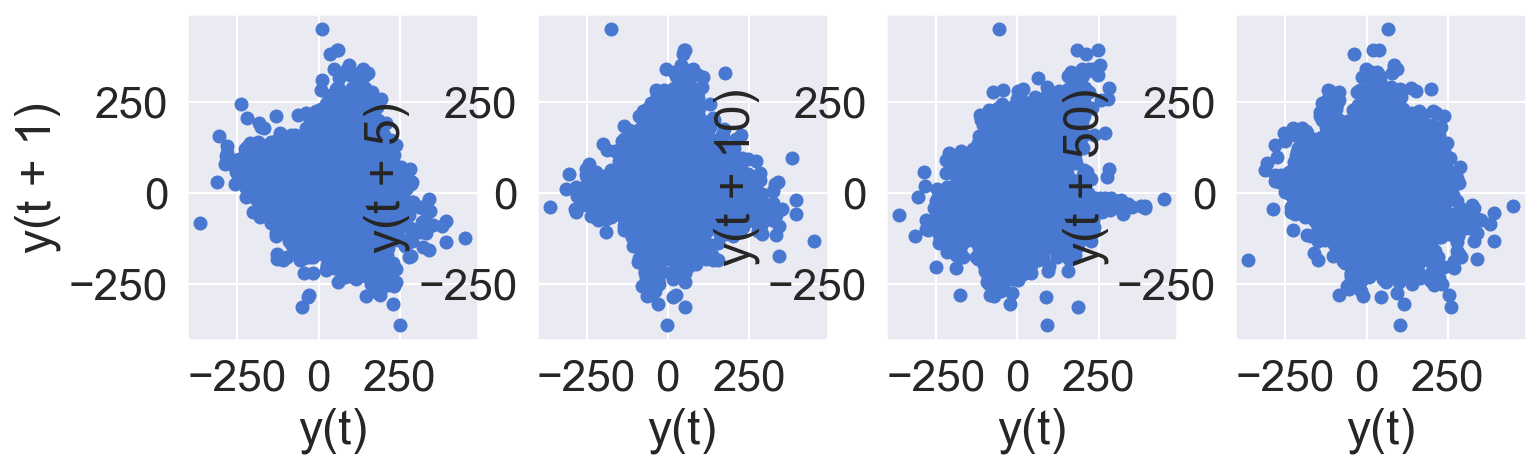

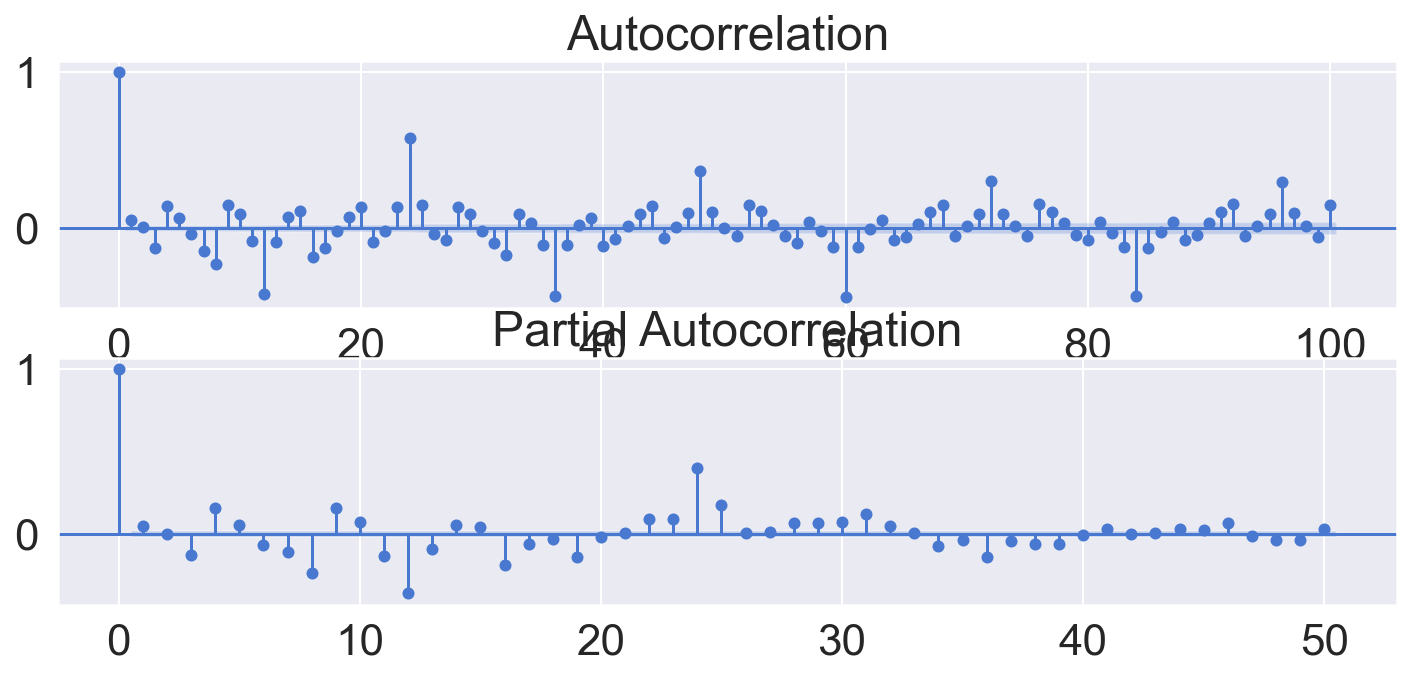

In [20]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

# 모델링
## Parameter Setting
logarithm = False
trend_diff_order = 0
seasonal_diff_order, seasonal_order = 0, 12
## 비정상성 데이터의 정상성 변환
if logarithm:
    Y_train_feR = np.log(Y_train_feR).copy()
    Y_test_feR = np.log(Y_test_feR).copy()
##############################
## SARIMA
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=(1,trend_diff_order,1), 
                                seasonal_order=(1,seasonal_diff_order,1,seasonal_order)).fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_tr_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR)).predicted_mean
pred_te_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR)).conf_int()
## 정상성 데이터의 비정상성 변환
if logarithm:
    Y_train_feR = np.exp(Y_train_feR).copy()
    Y_test_feR = np.exp(Y_test_feR).copy()
    pred_tr_ts_sarimax = np.exp(pred_tr_ts_sarimax).copy()
    pred_te_ts_sarimax = np.exp(pred_te_ts_sarimax).copy()
    pred_te_ts_sarimax_ci = np.exp(pred_te_ts_sarimax_ci).copy()
##############################
    
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train_feR, graph_on=True)

## 수요예측 SARIMAX 모델링

### 독립변수 일부 반영

In [21]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


#### 모델링

In [ ]:
## Additional Features
exog_tr = X_train_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]                             
## Parameter Setting
trend_diff_order = 0
seasonal_diff_order, seasonal_order = 0, 12
## SARIMAX
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=(1,trend_diff_order,1), 
                                seasonal_order=(1,seasonal_diff_order,1,seasonal_order), 
                                exog=exog_tr).fit()

In [ ]:
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_tr_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).predicted_mean
pred_te_ts_sarimax.name='prediction'
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).conf_int()

In [ ]:
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train_feR, graph_on=True)

### 독립변수 전체 반영

In [ ]:
## Parameter Setting
trend_diff_order = 0
seasonal_diff_order, seasonal_order = 0, 12
## SARIMAX
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=(1,trend_diff_order,1), 
                                seasonal_order=(1,seasonal_diff_order,1,seasonal_order), 
                                exog=X_train_feRSM).fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_tr_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=X_test_feRSM).predicted_mean
pred_te_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=X_test_feRSM).conf_int()
    
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train_feR, graph_on=True)

### 계절성 차수 변경 (12 -> 24)

In [ ]:
## Parameter Setting
trend_diff_order = 0
seasonal_diff_order, seasonal_order = 0, 24
## SARIMAX
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=(1,trend_diff_order,1), 
                                seasonal_order=(1,seasonal_diff_order,1,seasonal_order), 
                                exog=X_train_feRSM).fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_tr_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=X_test_feRSM).predicted_mean
pred_te_ts_sarimax.name = 'prediction'
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=X_test_feRSM).conf_int()
    
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train_feR, graph_on=True)

## 수요예측 자동화

### Auto-SARIMAX

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Number_of_Selected_X:  12


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(1, 1, 1, 12) AIC=142236.40044524026, BIC=142341.14267917175


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(1, 1, 2, 12) AIC=141418.21652908495, BIC=141530.44035115442


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(2, 1, 1, 12) AIC=141057.3330988703, BIC=141169.55692093977


 25%|████████████████████                                                            | 1/4 [26:22<1:19:07, 1582.64s/it]

Fit SARIMAX: trend_order=(1, 0, 1) seasonal_order=(2, 1, 2, 12) AIC=141281.6452508199, BIC=141401.35066102736


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(1, 1, 1, 12) AIC=142426.57932878862, BIC=142538.8031508581


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(1, 1, 2, 12) AIC=141352.3507726066, BIC=141472.05618281403


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(2, 1, 1, 12) AIC=141240.34730544247, BIC=141360.05271564992


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 50%|█████████████████████████████████████████                                         | 2/4 [59:16<56:39, 1699.90s/it]

Fit SARIMAX: trend_order=(1, 0, 2) seasonal_order=(2, 1, 2, 12) AIC=141256.97336881922, BIC=141384.16036716462


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(1, 1, 1, 12) AIC=142430.9680540586, BIC=142543.19187612808


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(1, 1, 2, 12) AIC=141224.2174751241, BIC=141343.92288533156


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(2, 1, 1, 12) AIC=141070.32520381533, BIC=141190.03061402278


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 75%|████████████████████████████████████████████████████████████                    | 3/4 [1:25:58<27:50, 1670.69s/it]

Fit SARIMAX: trend_order=(2, 0, 1) seasonal_order=(2, 1, 2, 12) AIC=141270.619200354, BIC=141397.8061986994


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(1, 1, 1, 12) AIC=142426.3768071371, BIC=142546.08221734455


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(1, 1, 2, 12) AIC=141414.0340896983, BIC=141541.2210880437


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(2, 1, 1, 12) AIC=140960.41611007476, BIC=141087.60310842015


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [1:56:17<00:00, 1744.29s/it]

Fit SARIMAX: trend_order=(2, 0, 2) seasonal_order=(2, 1, 2, 12) AIC=141235.22880165622, BIC=141369.8973881396
The smallest AIC is 140960.41611007476 for model SARIMAX(2, 0, 2)x(2, 1, 1, 12)



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                count   No. Observations:                13128
Model:             SARIMAX(2, 0, 2)x(2, 1, [1], 12)   Log Likelihood              -70463.208
Date:                              Thu, 19 Nov 2020   AIC                         140960.416
Time:                                      12:53:32   BIC                         141087.603
Sample:                                  01-01-2011   HQIC                        141002.894
                                       - 06-30-2012                                         
Covariance Type:                                opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.6980      0.093      7.522      0.000       0.516       0.880
count_seasonal  1378.1404     30.451     45.258      0.000    1318.458    1437.823
weather        -3.875e+04   1694.422    -22.869      0.000   -4.21e+04   -3.54e+04
count_lag2       396.3429     20.167     19.653      0.000     356.817     435.869
count_diff      1006.0782     10.613     94.796      0.000     985.277    1026.879
Quater_ver2    -6.417e+05   8126.526    -78.967      0.000   -6.58e+05   -6.26e+05
Hour           -1559.8433    635.846     -2.453      0.014   -2806.079    -313.608
workingday     -2118.5354   7043.329     -0.301      0.764   -1.59e+04    1.17e+04
DayofWeek        371.0573   1697.321      0.219      0.827   -2955.631    3697.746
ar.L1             -0.4629      0.011    -41.941      0.000      -0.485      -0.441
ar.L2              0.4655      0.009     54.352      0.000       0.449       0.482
ma.L1              1.4699      0.012    126.101      0.000       1.447       1.493
ma.L2              0.4795      0.011     45.018      0.000       0.459       0.500
ar.S.L12          -0.0124      0.008     -1.516      0.129      -0.028       0.004
ar.S.L24           0.4332      0.006     74.495      0.000       0.422       0.445
ma.S.L12          -0.9436      0.004   -252.385      0.000      -0.951      -0.936
sigma2          2693.1084     22.815    118.039      0.000    2648.391    2737.826
===================================================================================
Ljung-Box (Q):                     2456.59   Jarque-Bera (JB):             57369.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.50   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.77e+14. Standard errors may be unstable.
"""

MAE       MSE   MAPE
Train  33.86  2,860.51 103.04
Test  231.23 73,539.94 577.24

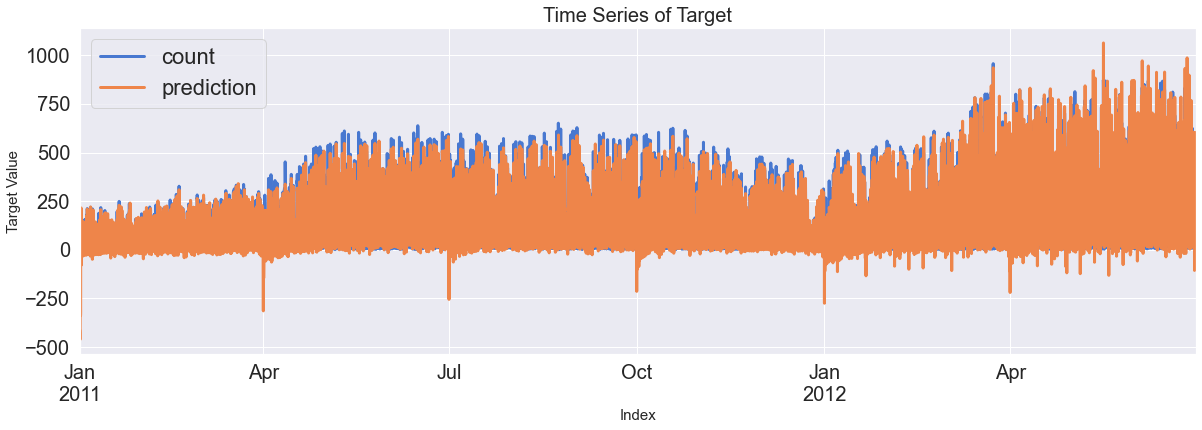

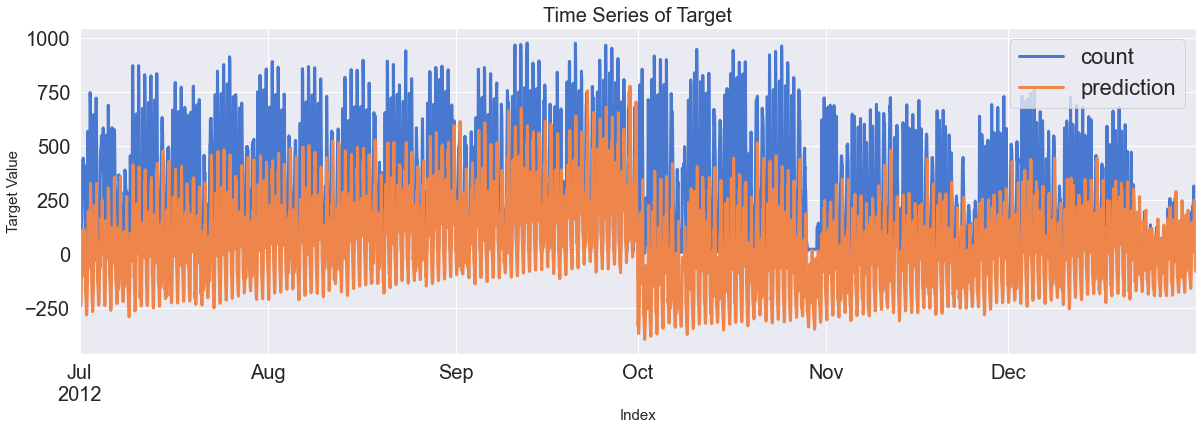

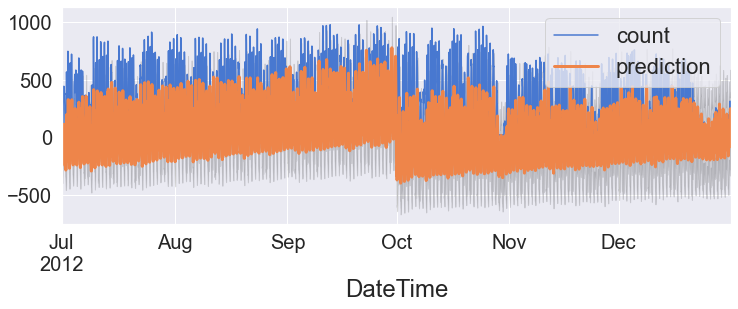

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                         -10.39               0.16       0.87   
p-value                                   0.00               0.10       0.00   
Used Lag                                 41.00              41.00        nan   
Used Observations                    13,086.00                nan        nan   
Critical Value(1%)                       -3.43                nan        nan   
Maximum Information Criteria        138,540.67                nan        nan   
Critical Value(10%)                        nan               0.35        nan   
Alternative                                nan                nan        nan   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                        39.01          295.74         1,304.41   
p-value                                 0.00            0.00             0.00   
Used Lag                                 nan             nan              nan   
Used Observations                        nan             nan              nan   
Critical Value(1%)                       nan             nan              nan   
Maximum Information Criteria             nan             nan              nan   
Critical Value(10%)                      nan             nan              nan   
Alternative                              nan             nan              nan   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                      2,939.87               2.47  
p-value                                  0.00               0.00  
Used Lag                                  nan                NaN  
Used Observations                         nan                NaN  
Critical Value(1%)                        nan                NaN  
Maximum Information Criteria              nan                NaN  
Critical Value(10%)                       nan                NaN  
Alternative                               nan          two-sided

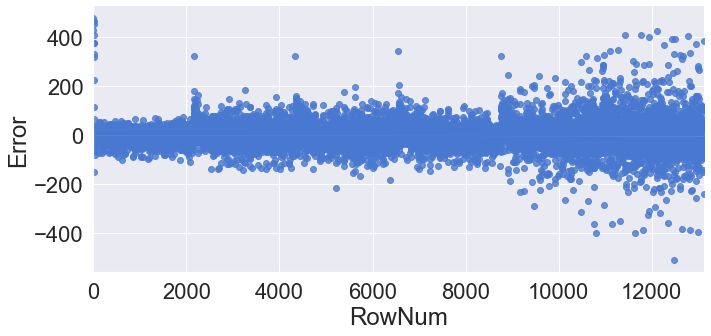

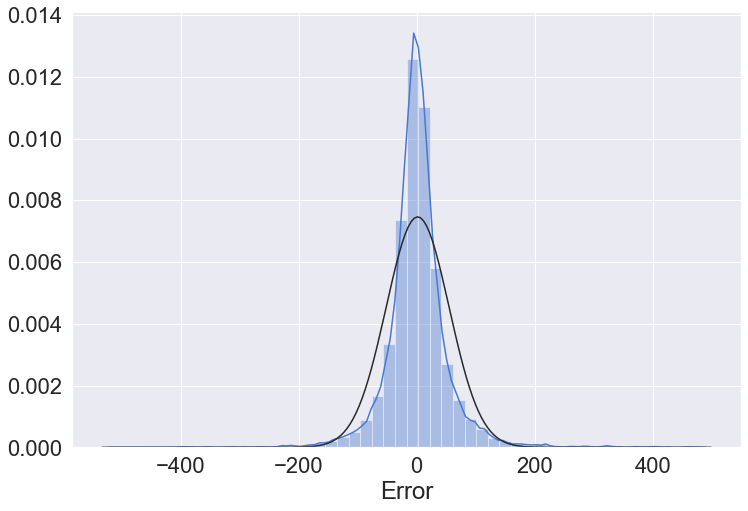

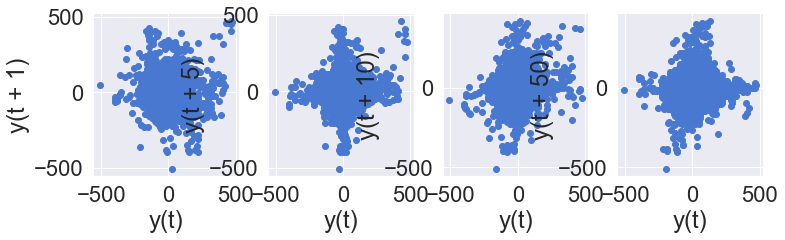

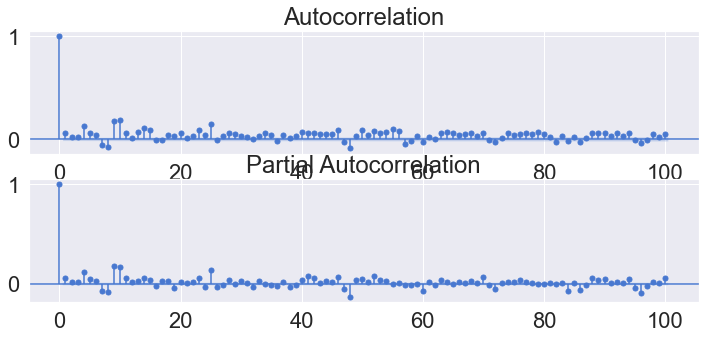

In [12]:
# Data Loading
# location = 'https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv'
location = './Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)

# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(preprocessing.Normalizer(), X_train_feR, X_test_feR)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_feRS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_feRS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_feRSM, X_test_feRSM = X_train_feRS[X_colname_vif].copy(), X_test_feRS[X_colname_vif].copy()
#########################

# 모델링
## Additional Features
exog_tr = X_train_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]                             
## Parameter Setting
p, q = range(1,3), range(1,3)
d = range(0,1)
P, Q = range(1,3), range(1,3)
D = range(1,2)
m = 12
trend_pdq = list(product(p, d, q))
seasonal_pdq = [(candi[0], candi[1], candi[2], m) for candi in list(product(P, D, Q))]
## SARIMAX
AIC = []
SARIMAX_order = []
for trend_param in tqdm(trend_pdq):
    for seasonal_params in seasonal_pdq:
        try:
            result =sm.tsa.SARIMAX(Y_train_feR, trend='c', 
                                   order=trend_param, seasonal_order=seasonal_params, exog=exog_tr).fit()
            print('Fit SARIMAX: trend_order={} seasonal_order={} AIC={}, BIC={}'.format(trend_param, seasonal_params, result.aic, result.bic, end='\r'))
            AIC.append(result.aic)
            SARIMAX_order.append([trend_param, seasonal_params])
        except:
            continue
## Parameter Selection
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_order[AIC.index(min(AIC))][0],
                                                             SARIMAX_order[AIC.index(min(AIC))][1]))
## Auto-SARIMAX Fitting
fit_ts_sarimax = sm.tsa.SARIMAX(Y_train_feR, trend='c', order=SARIMAX_order[AIC.index(min(AIC))][0], 
                                seasonal_order=SARIMAX_order[AIC.index(min(AIC))][1], exog=exog_tr).fit()
display(fit_ts_sarimax.summary())
pred_tr_ts_sarimax = fit_ts_sarimax.predict()
pred_te_ts_sarimax = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).predicted_mean
pred_te_ts_sarimax_ci = fit_ts_sarimax.get_forecast(len(Y_test_feR), exog=exog_te).conf_int()
    
# 검증
Score_ts_sarimax, Resid_tr_ts_sarimax, Resid_te_ts_sarimax = evaluation_trte(Y_train_feR, pred_tr_ts_sarimax, 
                                                                             Y_test_feR, pred_te_ts_sarimax, graph_on=True)
display(Score_ts_sarimax)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_sarimax, index=Y_test_feR.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).index,
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_sarimax_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()

# 잔차진단
error_analysis(Resid_tr_ts_sarimax, ['Error'], Y_train_feR, graph_on=True)

### Auto-Arima

In [86]:
import pmdarima as pm
from pmdarima import model_selection

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=144398.808, Time=0.77 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=143450.553, Time=10.76 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=143011.308, Time=50.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=144398.808, Time=0.74 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=143067.218, Time=5.85 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=69.99 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=143044.516, Time=19.24 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=144388.796, Time=7.63 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=143011.629, Time=30.23 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=142963.071, Time=22.57 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=142876.386, Time=20.81 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=142958.536, Time=22.90 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=67.35 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=140896.772, Time=26.99

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                13128
Model:             SARIMAX(1, 1, 2)x(1, 0, [], 12)   Log Likelihood              -70429.459
Date:                             Thu, 03 Jun 2021   AIC                         140886.918
Time:                                     19:06:27   BIC                         140991.672
Sample:                                 01-01-2011   HQIC                        140921.903
                                      - 06-30-2012                                         
Covariance Type:                               opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0426      0.020      2.128      0.033       0.003       0.082
count_seasonal  1490.1268     11.406    130.646      0.000    1467.772    1512.482
weather        -6706.0473   1959.863     -3.422      0.001   -1.05e+04   -2864.786
count_lag2       -94.5844     20.887     -4.528      0.000    -135.522     -53.647
count_diff       604.0547      8.075     74.802      0.000     588.227     619.882
Quater_ver2    -5.012e+05   1.09e+04    -45.819      0.000   -5.23e+05    -4.8e+05
Hour             653.1578    362.179      1.803      0.071     -56.700    1363.016
workingday     -4.416e+04   1.06e+04     -4.184      0.000   -6.49e+04   -2.35e+04
DayofWeek      -8695.2112   2487.282     -3.496      0.000   -1.36e+04   -3820.227
ar.L1              0.6081      0.010     61.912      0.000       0.589       0.627
ma.L1             -0.4690      0.010    -46.195      0.000      -0.489      -0.449
ma.L2             -0.4961      0.009    -54.457      0.000      -0.514      -0.478
ar.S.L12          -0.0297      0.009     -3.203      0.001      -0.048      -0.012
sigma2          2645.4677     19.672    134.476      0.000    2606.910    2684.025
===================================================================================
Ljung-Box (L1) (Q):                   6.24   Jarque-Bera (JB):             16101.29
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               3.45   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MAE       MSE   MAPE
Train  34.34  2,687.96  96.67
Test  154.46 40,839.26 209.85

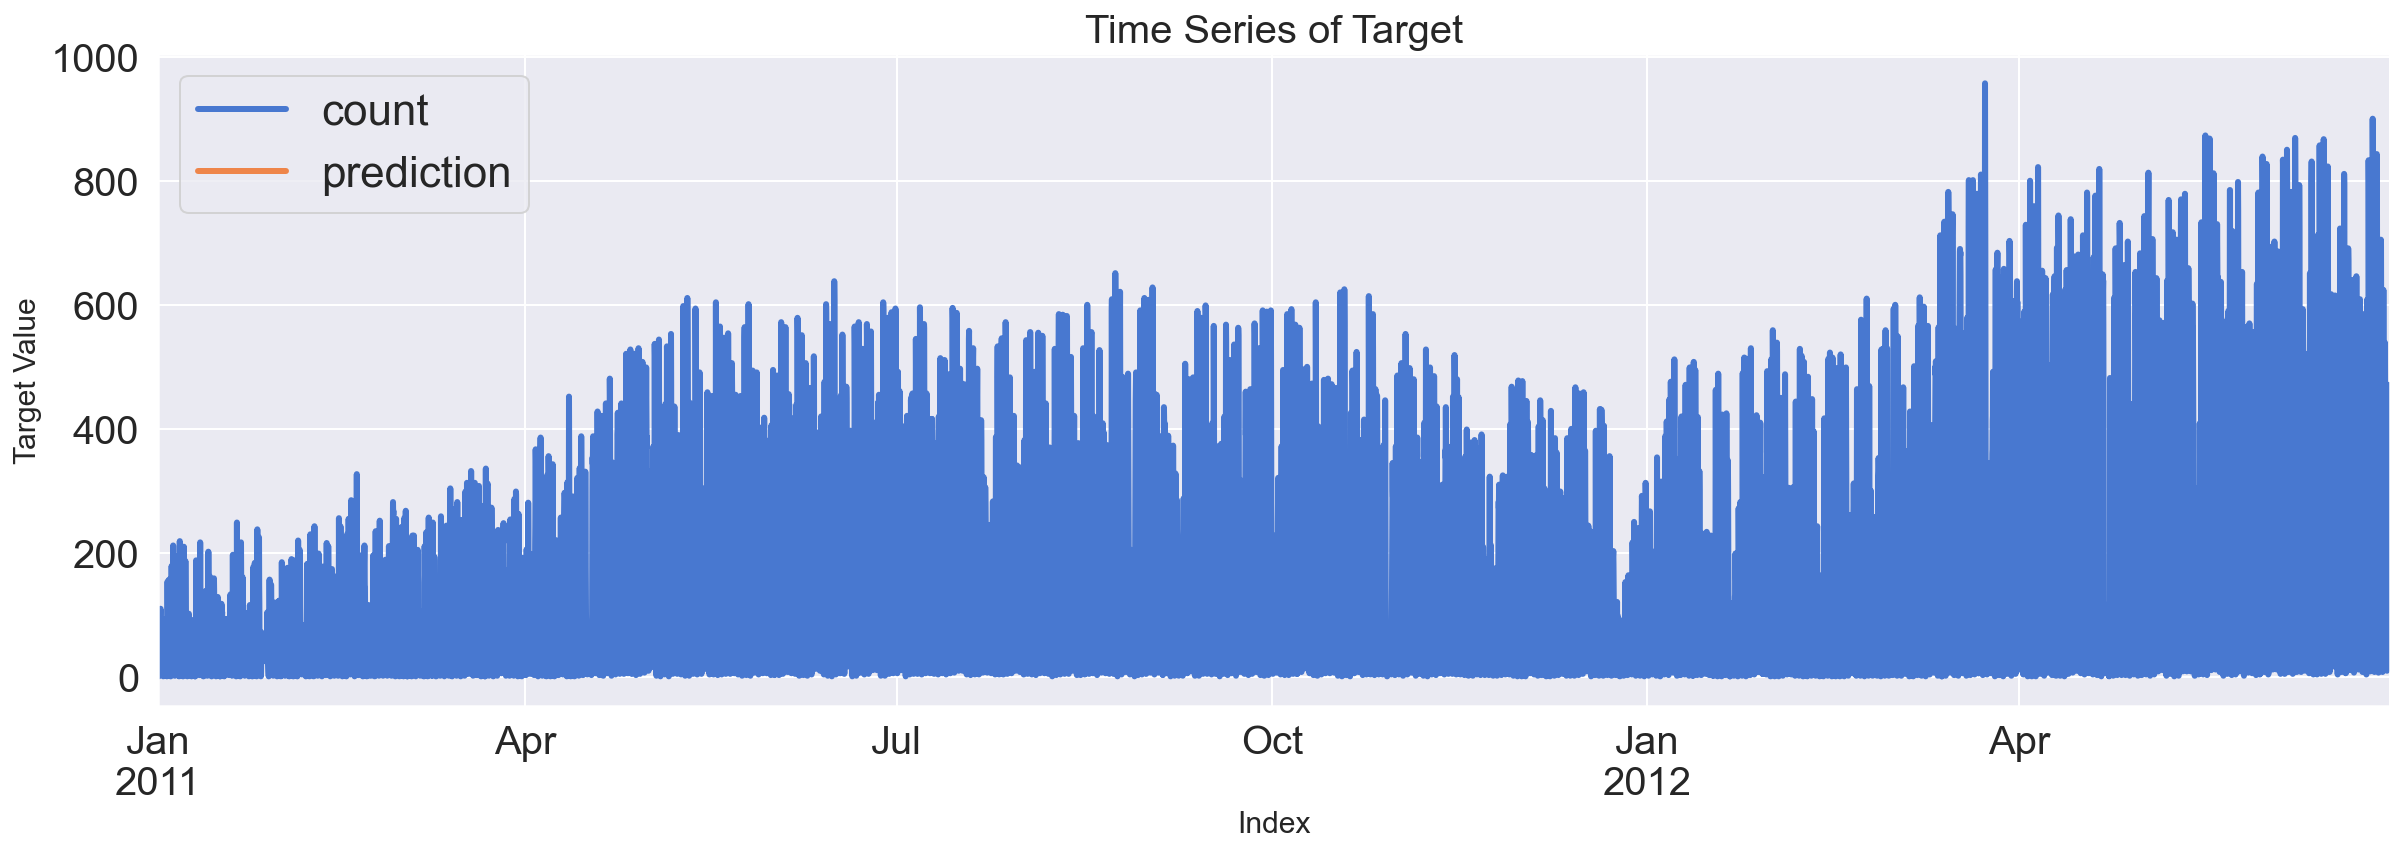

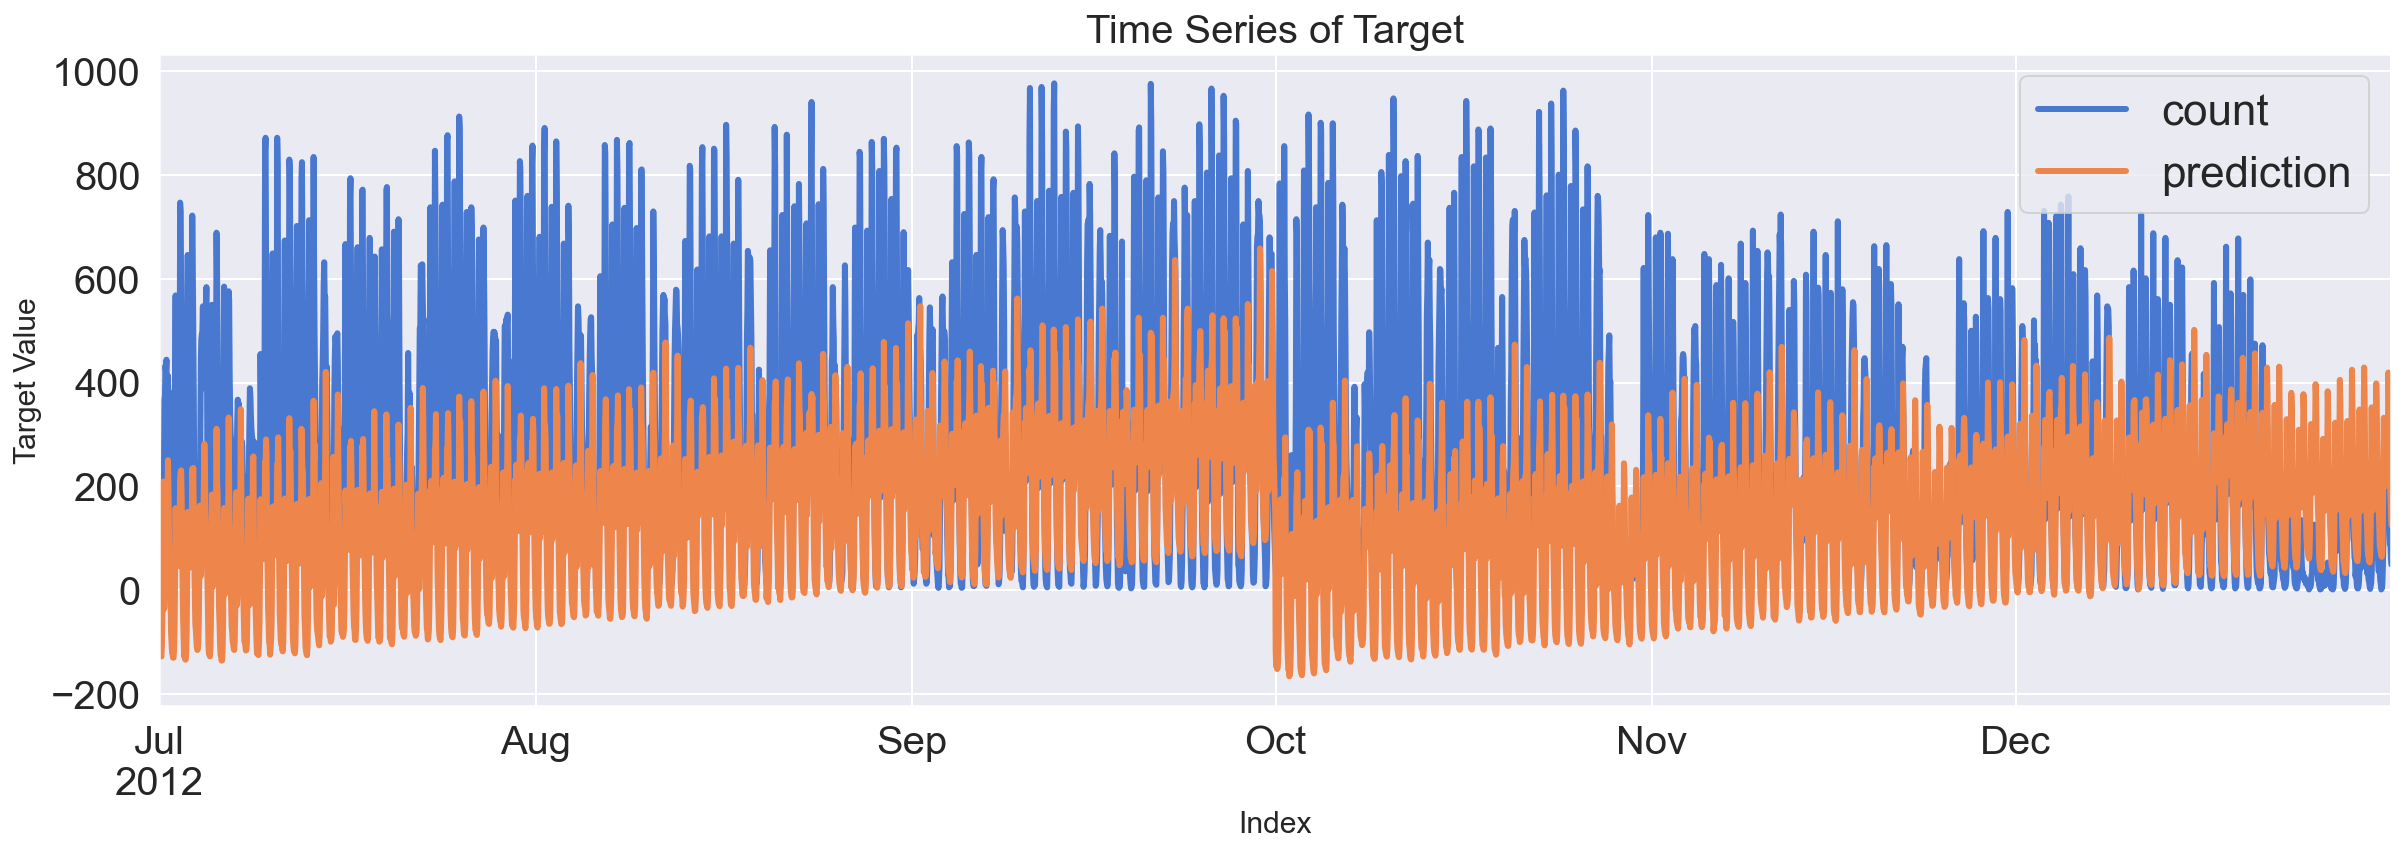

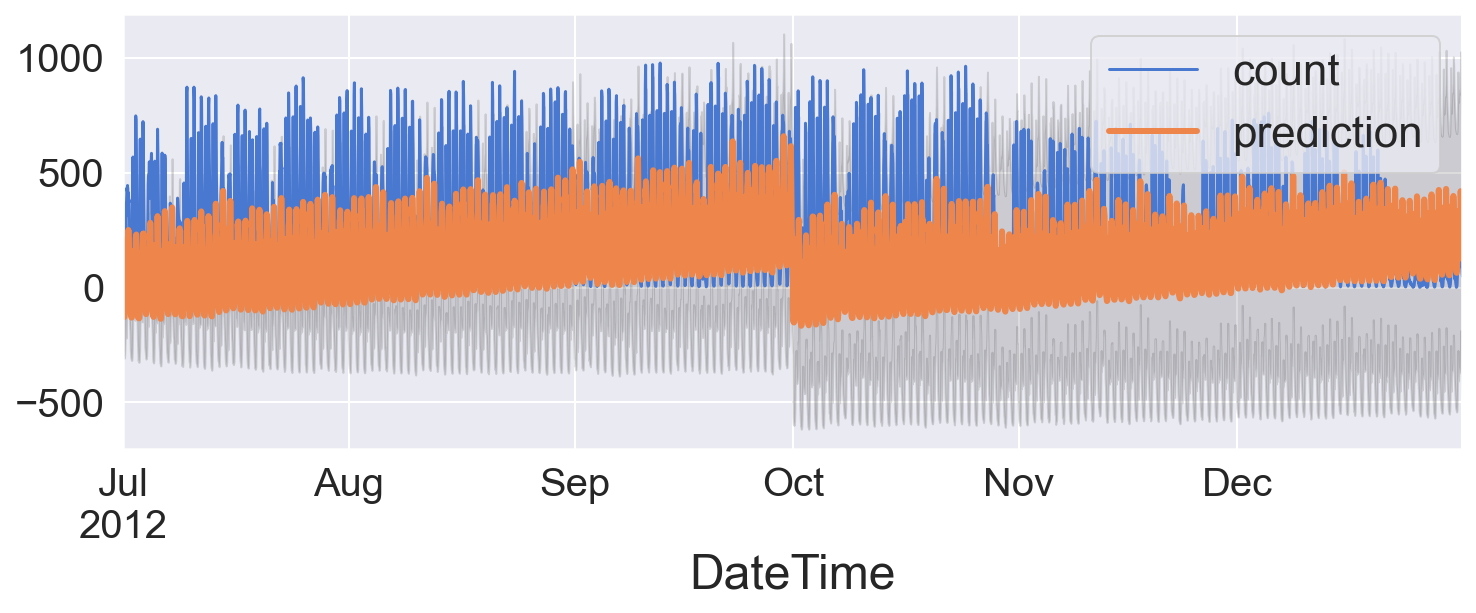

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

ADF:추세가 어느정도 제거되어 귀무가설(비정상)을 기각합니다.
KPSS:계절성이 어느정도 제거되어 귀무가설(정상) 기각 못합니다.


Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                         -16.53               0.04       0.92   
p-value                                   0.00               0.10       0.00   
Used Lag                                 40.00              41.00        nan   
Used Observations                    13,087.00                nan        nan   
Critical Value(1%)                       -3.43                nan        nan   
Maximum Information Criteria        136,781.15                nan        nan   
Critical Value(10%)                        nan               0.35        nan   
Alternative                                nan                nan        nan   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                         6.43           57.79         1,333.95   
p-value                                 0.01            0.00             0.00   
Used Lag                                 nan             nan              nan   
Used Observations                        nan             nan              nan   
Critical Value(1%)                       nan             nan              nan   
Maximum Information Criteria             nan             nan              nan   
Critical Value(10%)                      nan             nan              nan   
Alternative                              nan             nan              nan   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                      4,269.55               2.45  
p-value                                  0.00               0.00  
Used Lag                                  nan                NaN  
Used Observations                         nan                NaN  
Critical Value(1%)                        nan                NaN  
Maximum Information Criteria              nan                NaN  
Critical Value(10%)                       nan                NaN  
Alternative                               nan          two-sided

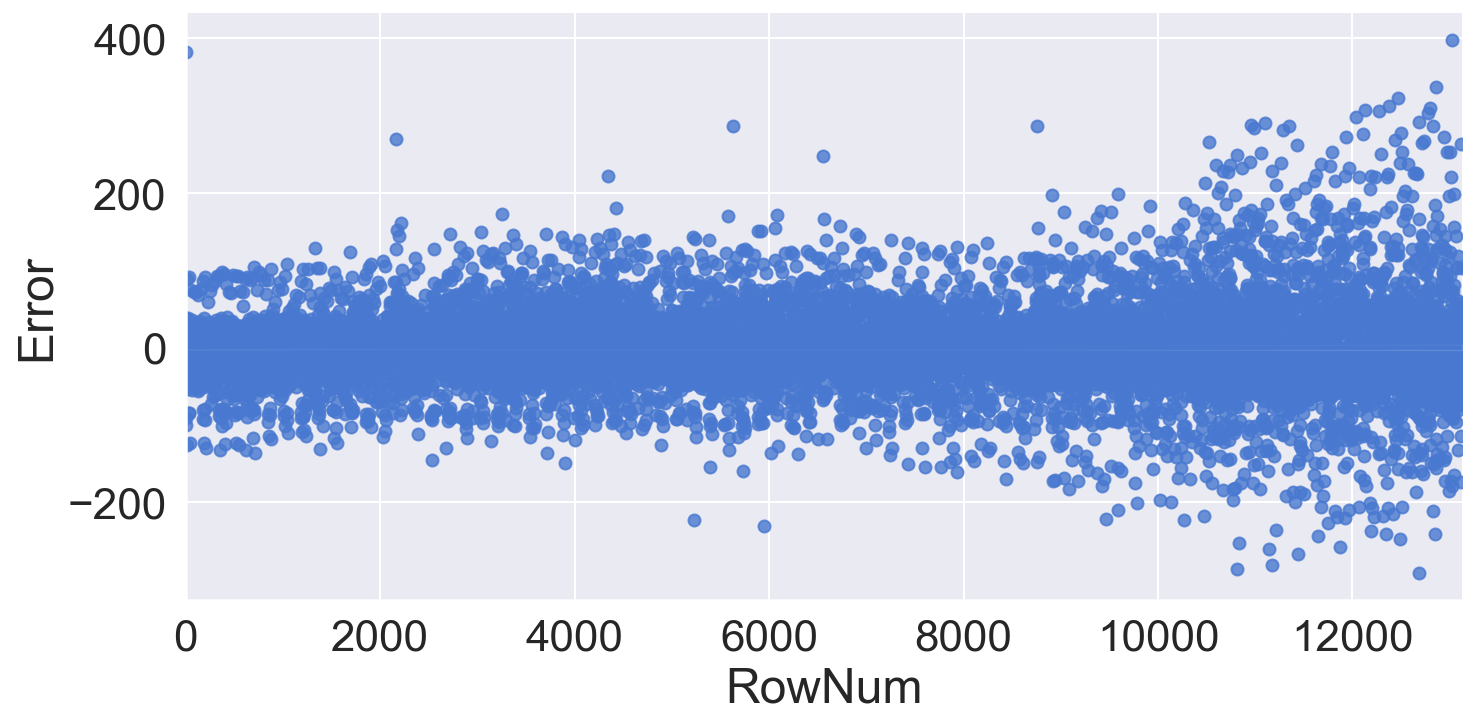

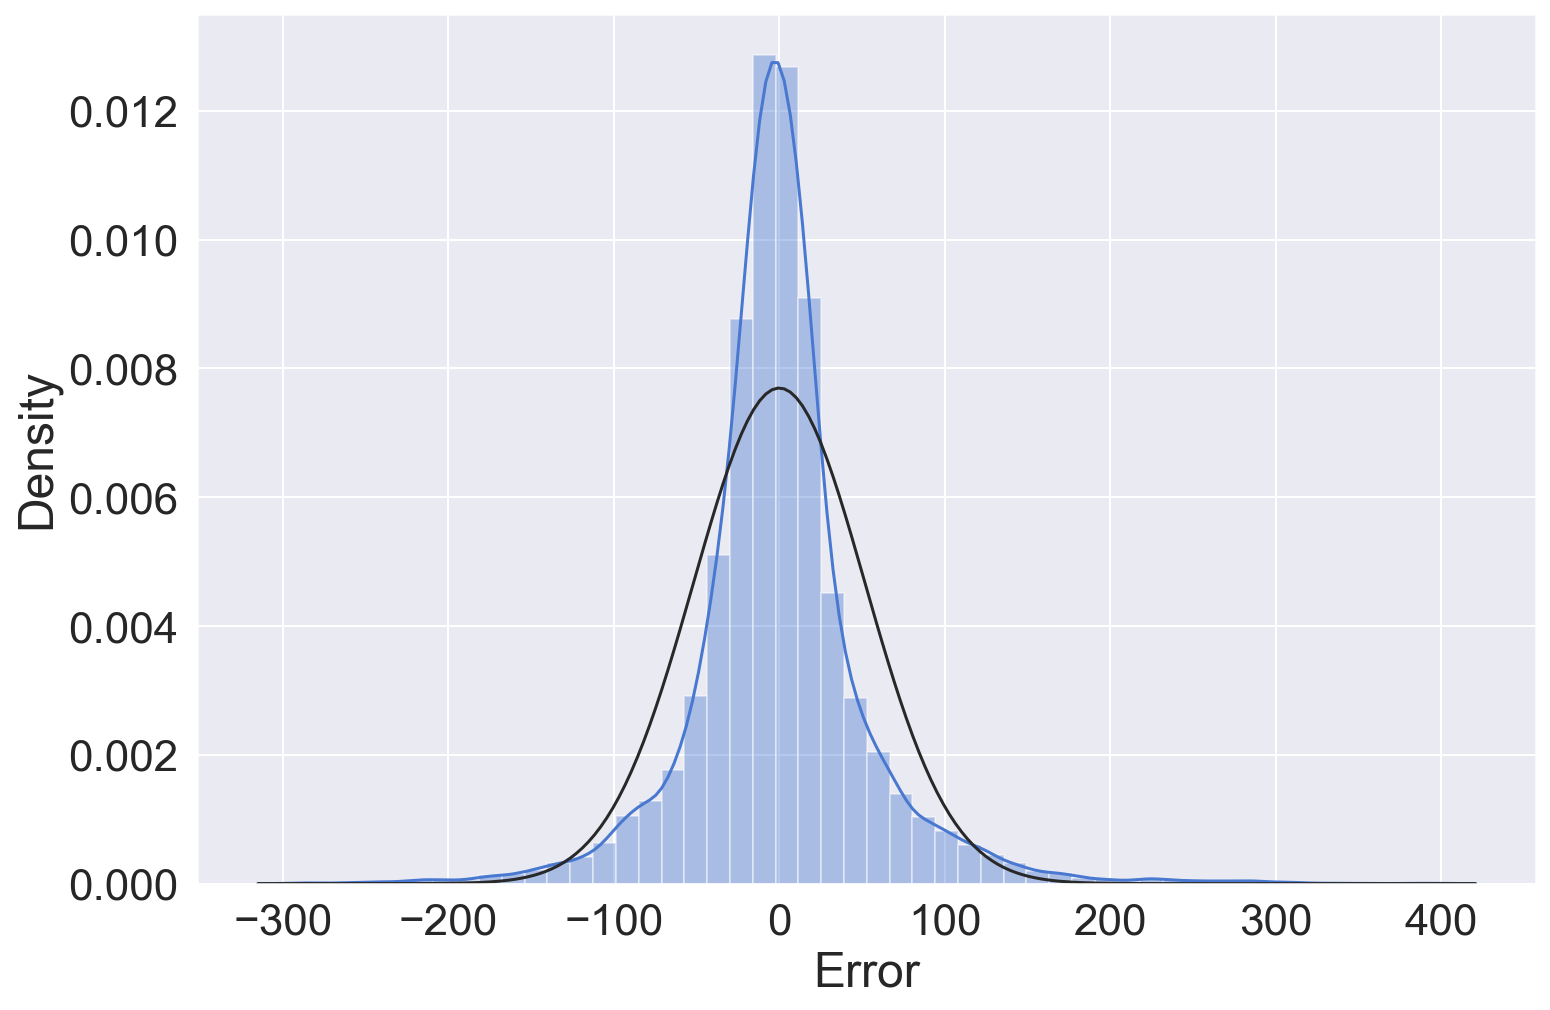

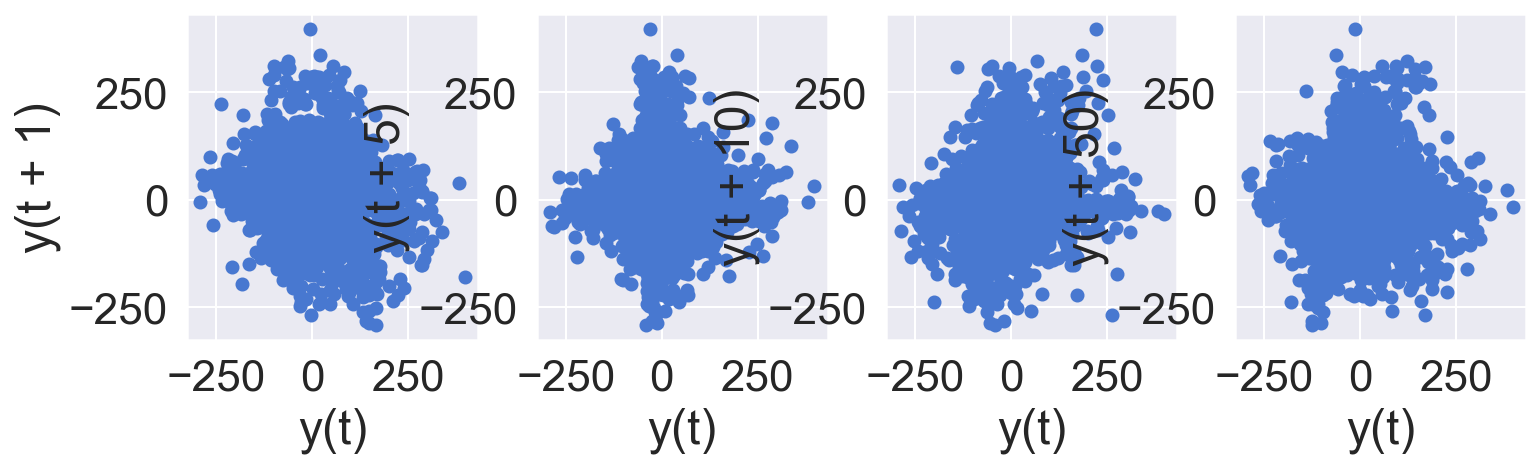

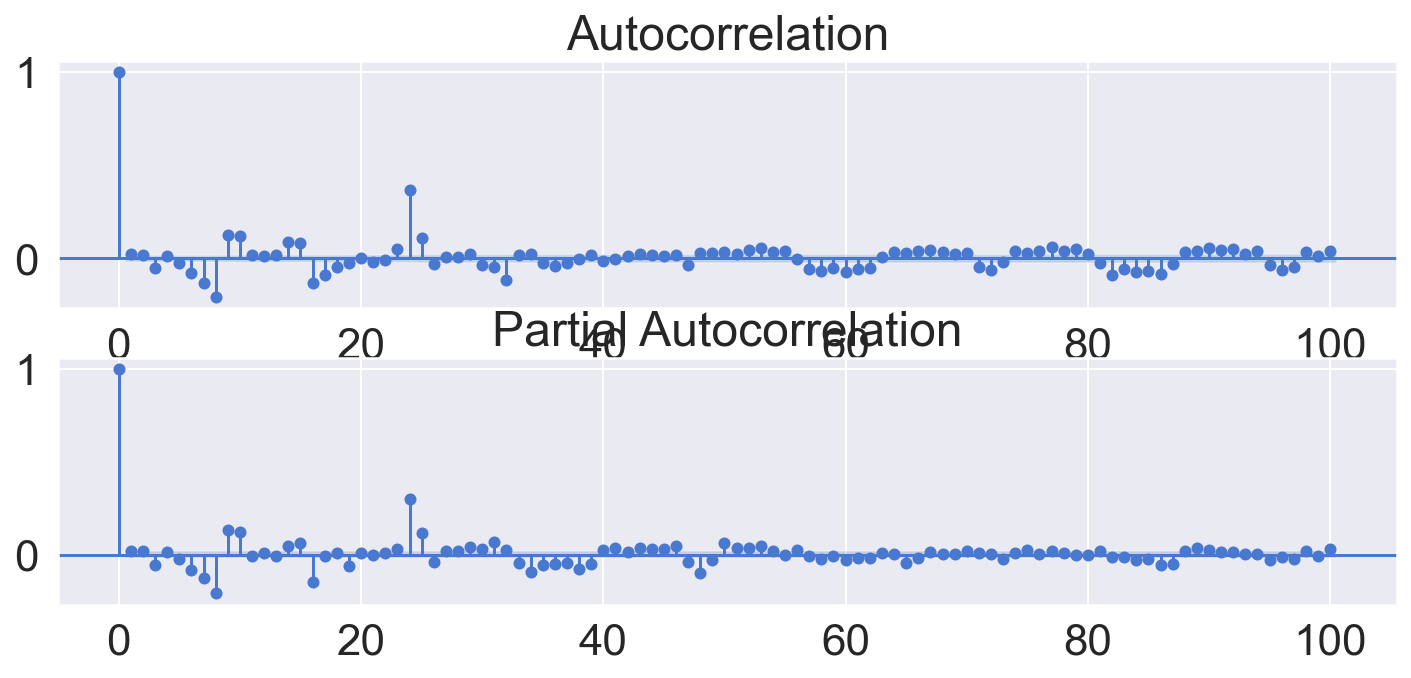

In [88]:
# 모델링
## Additional Features
exog_tr = X_train_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]
exog_te = X_test_feRSM[['count_seasonal', 'weather', 'count_lag2', 'count_diff', 'Quater_ver2', 'Hour', 'workingday', 'DayofWeek']]                             
## Auto-ARIMA
fit_ts_autoarima = pm.auto_arima(Y_train_feR, exogenous=exog_tr, stationary=False,
                               trend='c', start_p=0, start_q=0, max_p=2, max_q=2, max_d=1,
                               seasonal=True, start_P=0, start_Q=0, max_P=1, max_Q=1, m=12,
                               stepwise=True, trace=True)
display(fit_ts_autoarima.summary())


In [93]:
pred_te_ts_autoarima

array([-124.57418144, -127.12757721, -125.86783975, ...,  181.5283552 ,
        152.10218915,  124.48377951])

MAE       MSE   MAPE
Train  34.34  2,687.96  96.67
Test  154.46 40,839.26 209.85

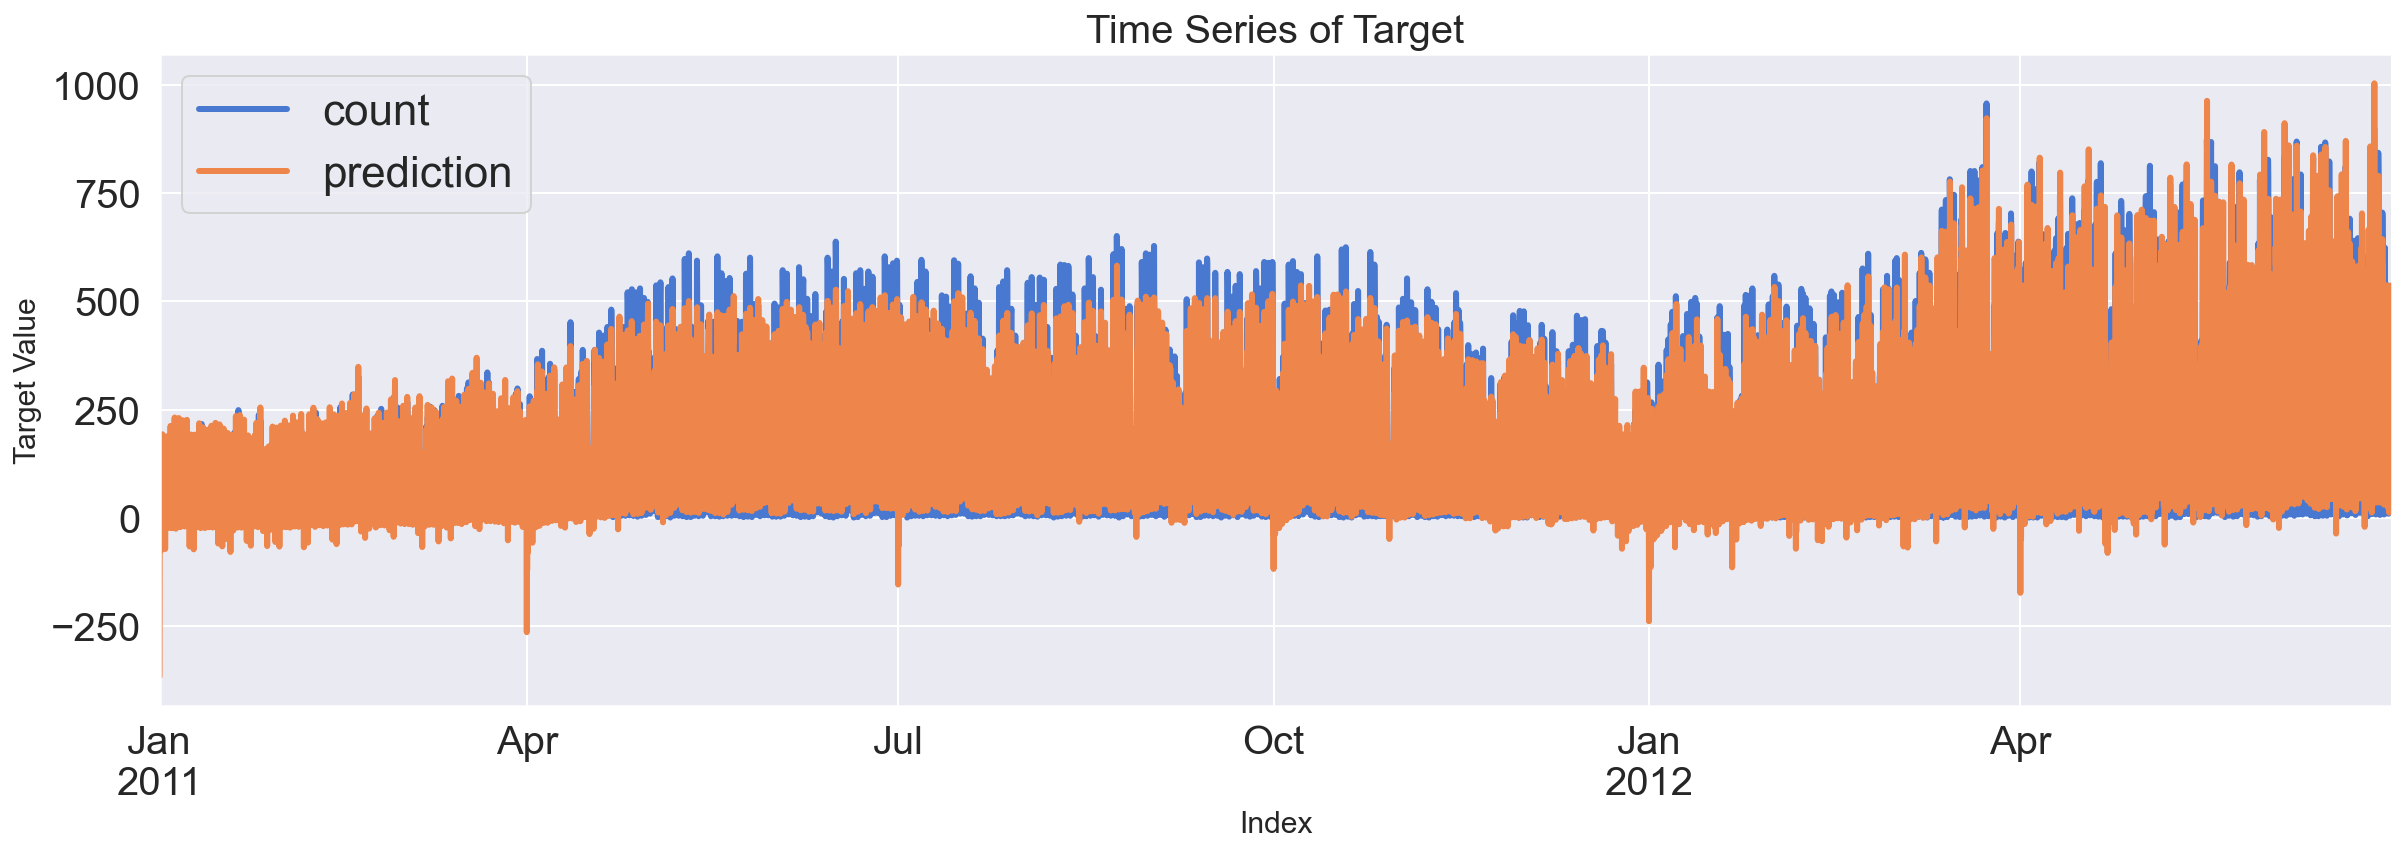

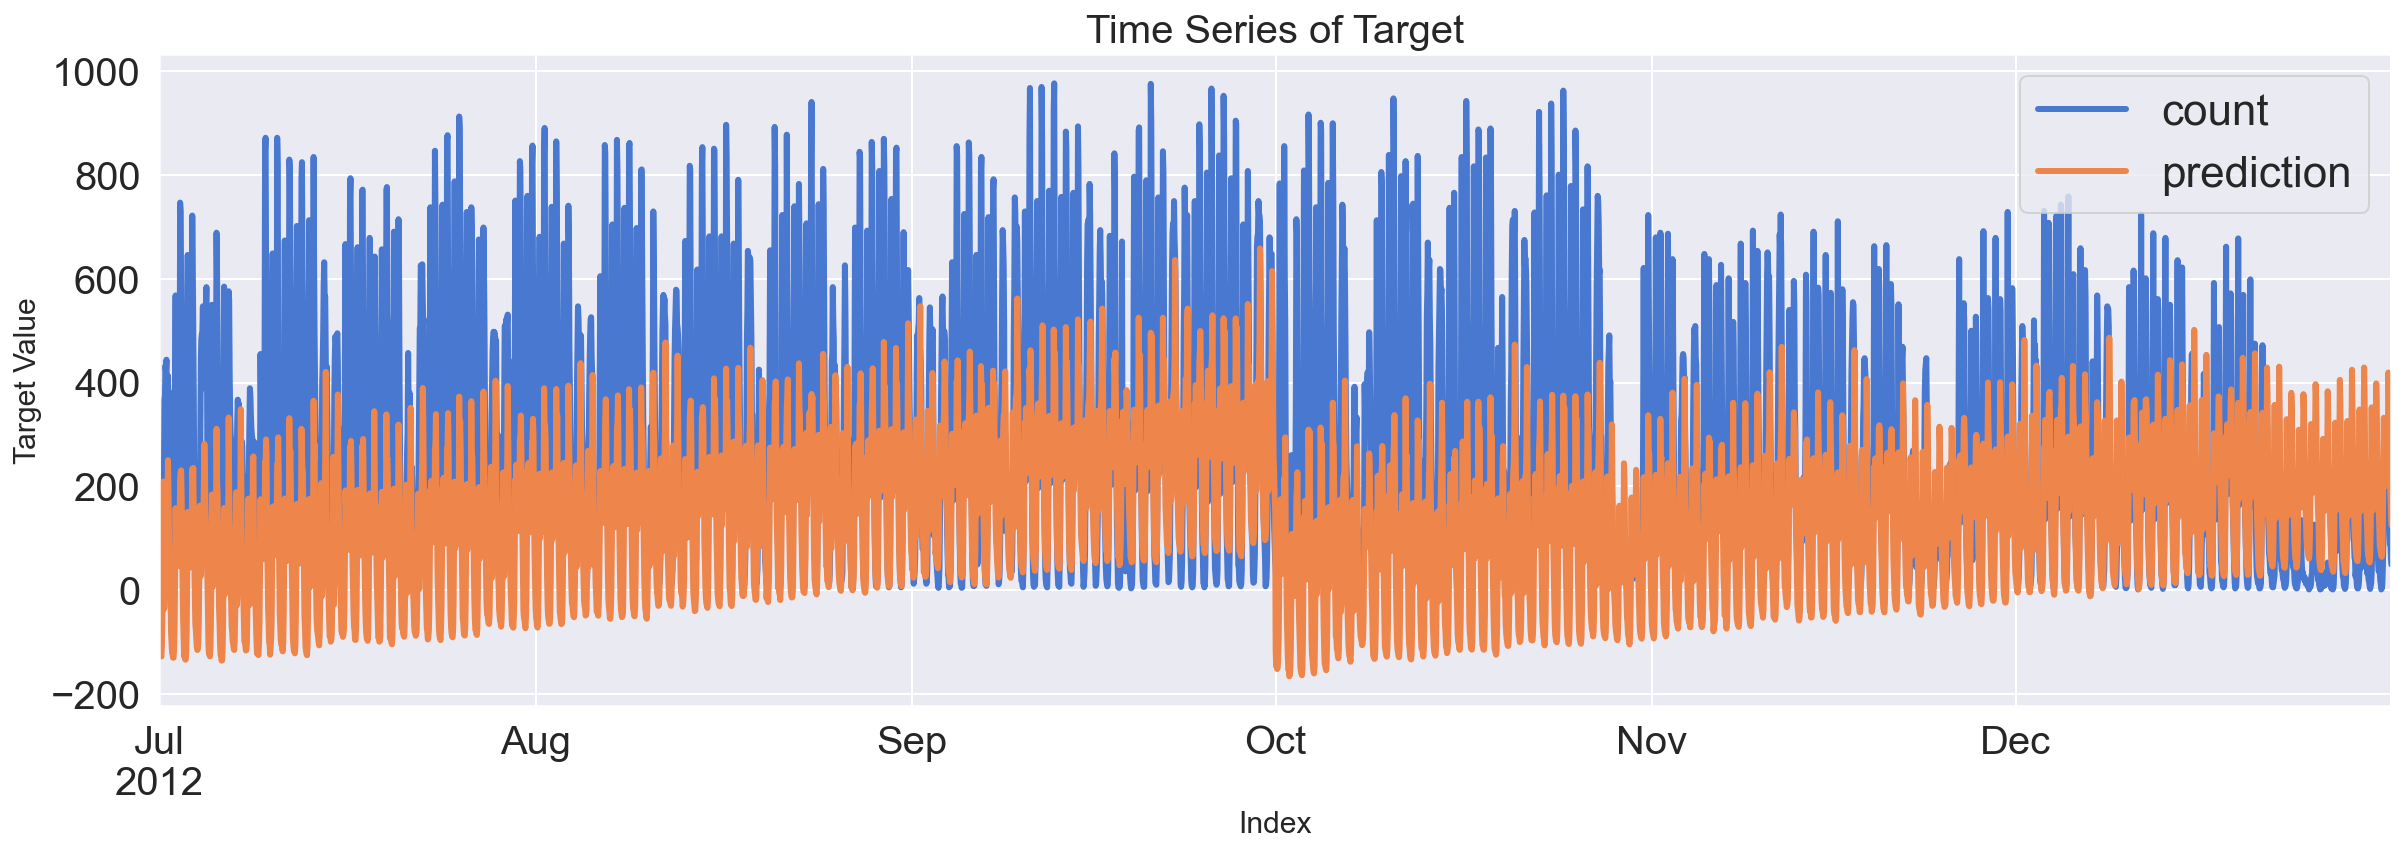

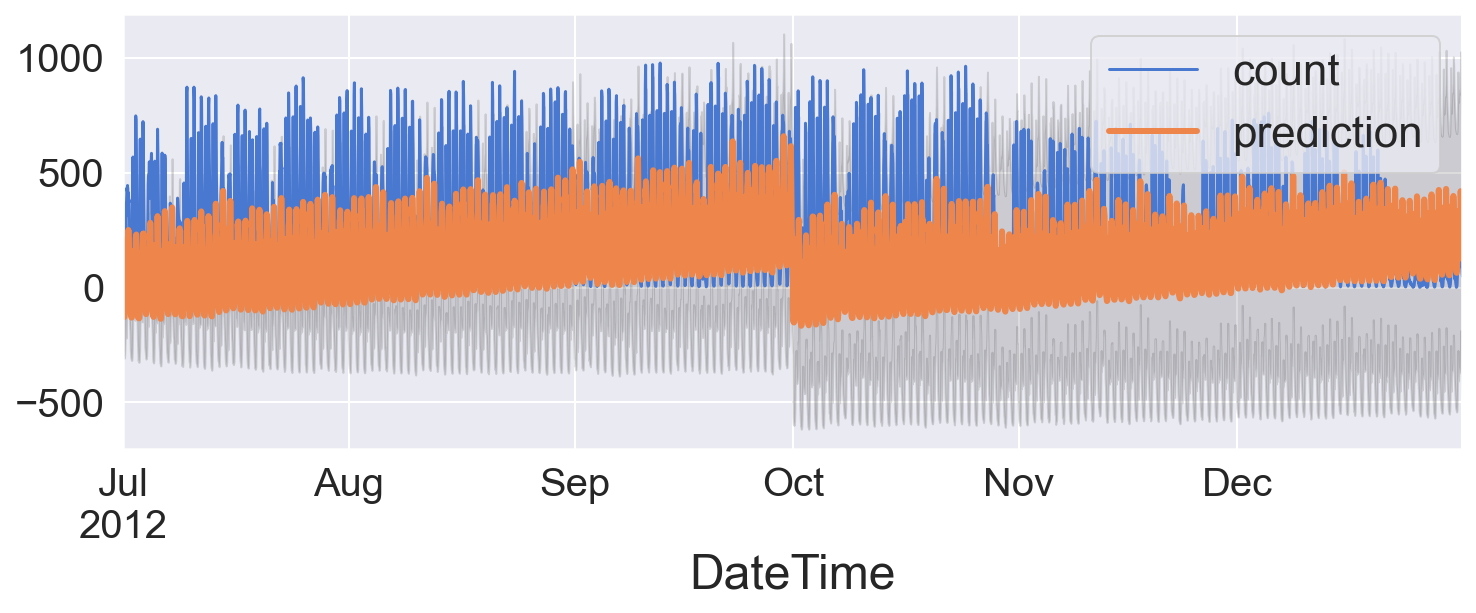

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

ADF:추세가 어느정도 제거되어 귀무가설(비정상)을 기각합니다.
KPSS:계절성이 어느정도 제거되어 귀무가설(정상) 기각 못합니다.


Stationarity_adf  Stationarity_kpss  Normality  \
Test Statistics                         -16.53               0.04       0.92   
p-value                                   0.00               0.10       0.00   
Used Lag                                 40.00              41.00        nan   
Used Observations                    13,087.00                nan        nan   
Critical Value(1%)                       -3.43                nan        nan   
Maximum Information Criteria        136,781.15                nan        nan   
Critical Value(10%)                        nan               0.35        nan   
Alternative                                nan                nan        nan   

                              Autocorr(lag1)  Autocorr(lag5)  Autocorr(lag10)  \
Test Statistics                         6.43           57.79         1,333.95   
p-value                                 0.01            0.00             0.00   
Used Lag                                 nan             nan              nan   
Used Observations                        nan             nan              nan   
Critical Value(1%)                       nan             nan              nan   
Maximum Information Criteria             nan             nan              nan   
Critical Value(10%)                      nan             nan              nan   
Alternative                              nan             nan              nan   

                              Autocorr(lag50) Heteroscedasticity  
Test Statistics                      4,269.55               2.45  
p-value                                  0.00               0.00  
Used Lag                                  nan                NaN  
Used Observations                         nan                NaN  
Critical Value(1%)                        nan                NaN  
Maximum Information Criteria              nan                NaN  
Critical Value(10%)                       nan                NaN  
Alternative                               nan          two-sided

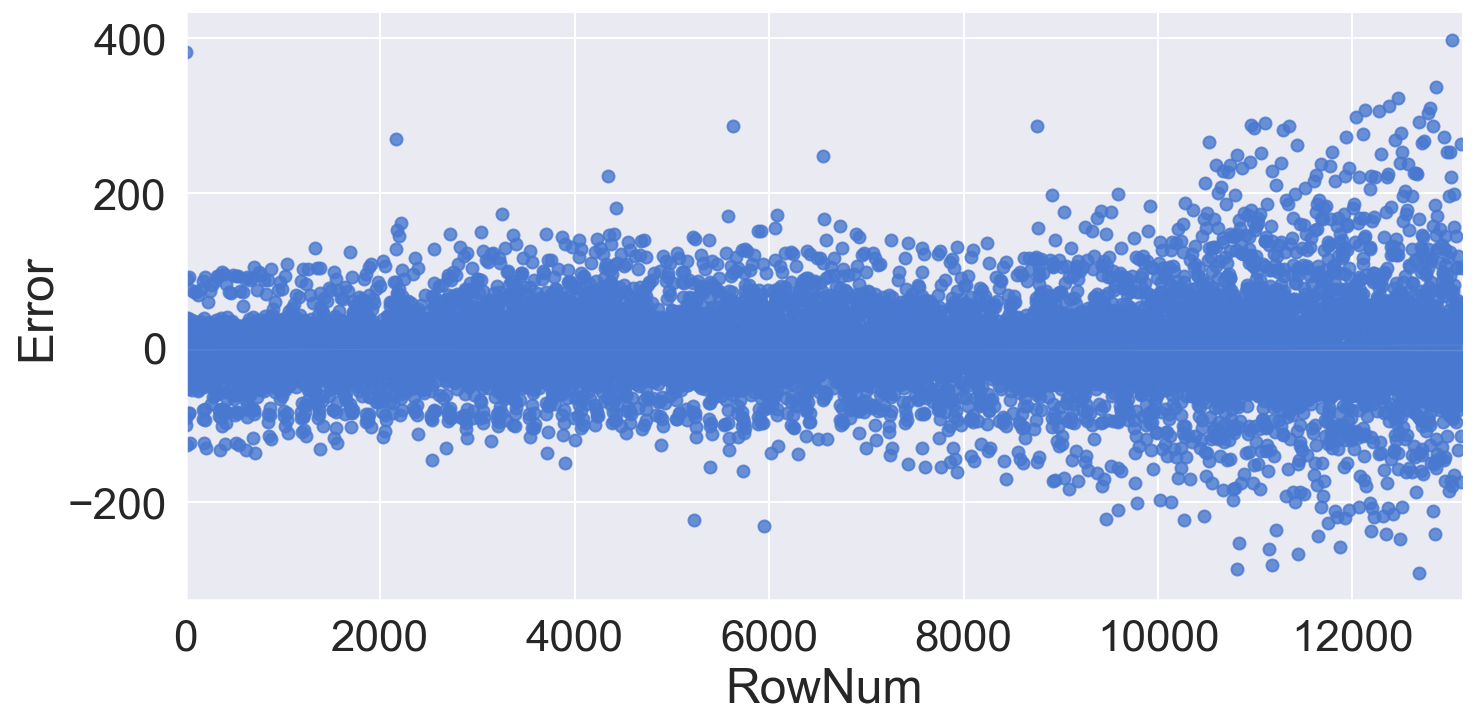

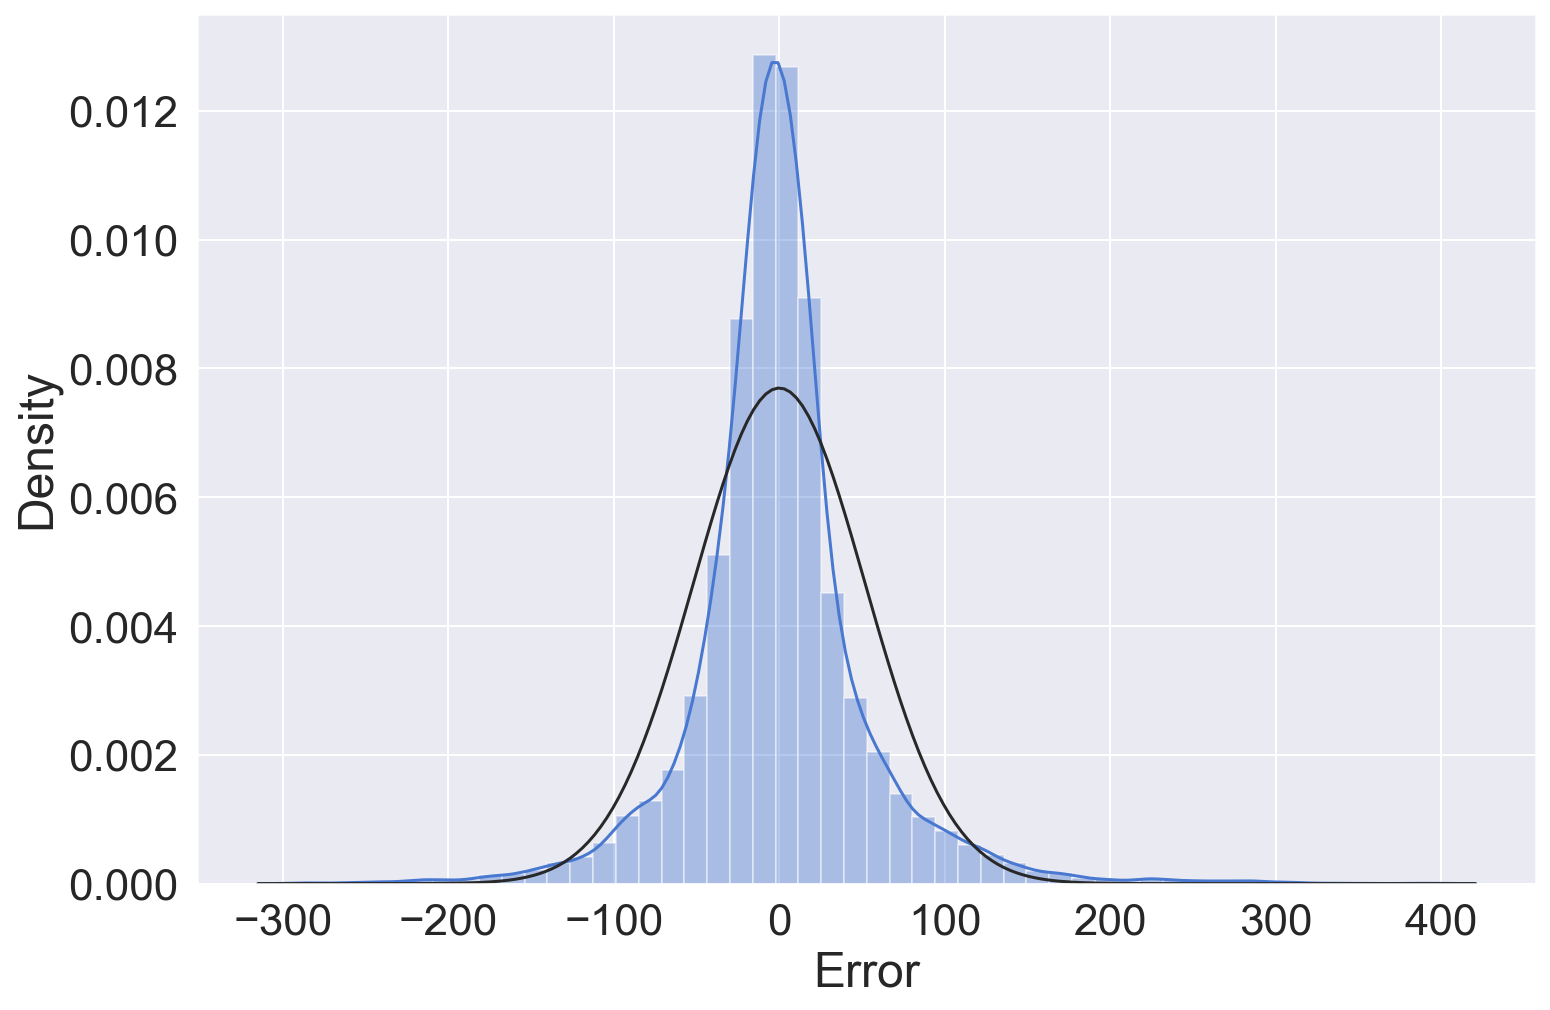

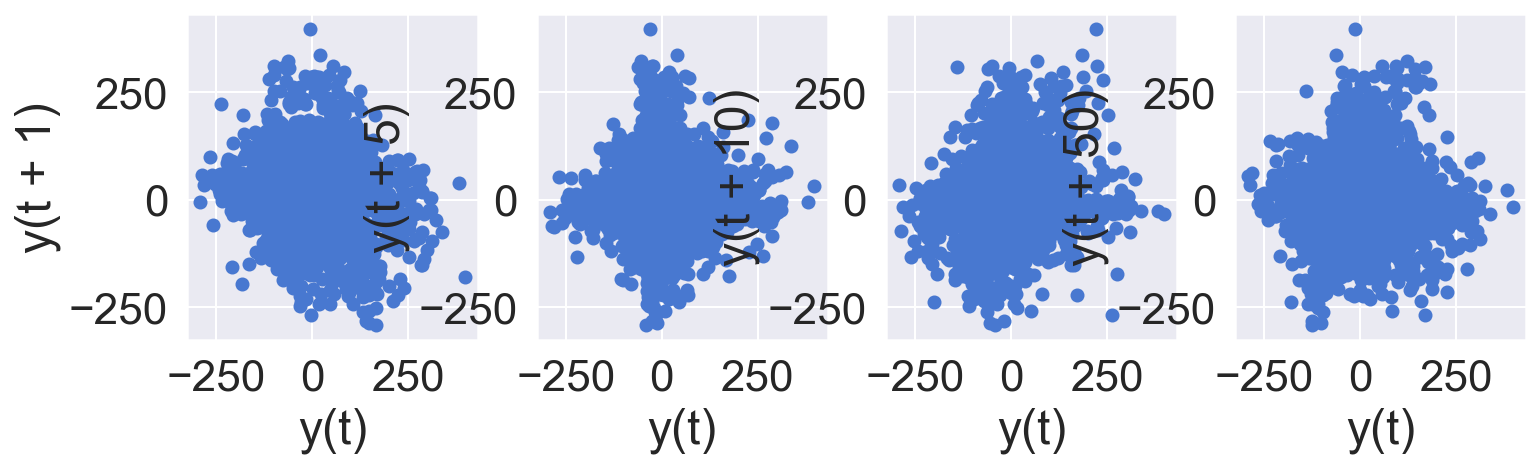

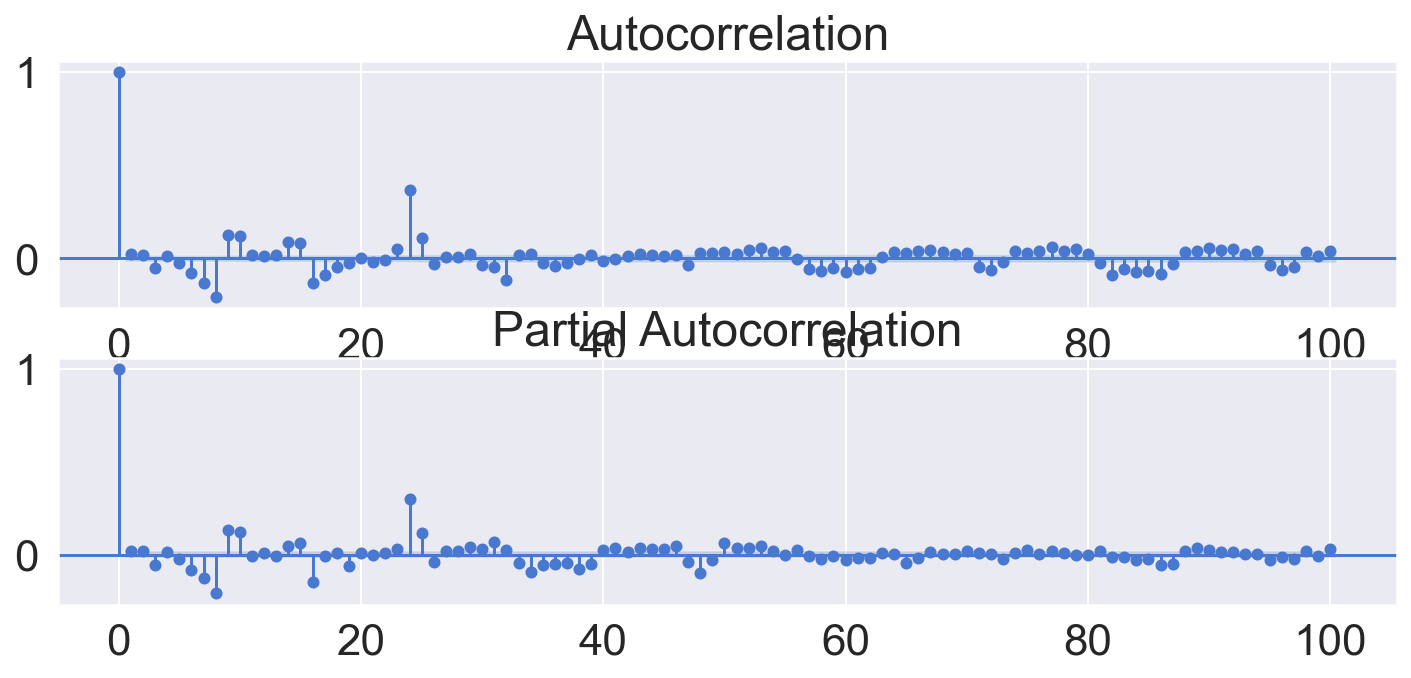

In [96]:
pred_tr_ts_autoarima = fit_ts_autoarima.predict_in_sample(exogenous=exog_tr)
pred_tr_ts_autoarima = pd.Series(pred_tr_ts_autoarima, name='prediction', index=Y_train_feR.index)

pred_te_ts_autoarima = fit_ts_autoarima.predict(len(Y_test_feR), exogenous=exog_te, return_conf_int=True)[0]
pred_te_ts_autoarima = pd.Series(pred_te_ts_autoarima, name='prediction', index=Y_test_feR.index)
pred_te_ts_autoarima_ci = fit_ts_autoarima.predict(len(Y_test_feR), exogenous=exog_te, return_conf_int=True)[1]
   
# 검증
Score_ts_autoarima, Resid_tr_ts_autoarima, Resid_te_ts_autoarima = evaluation_trte(Y_train_feR, pred_tr_ts_autoarima, 
                                                                              Y_test_feR, pred_te_ts_autoarima, graph_on=True)
display(Score_ts_autoarima)
ax = pd.DataFrame(Y_test_feR).plot(figsize=(12,4))
temp =pd.DataFrame(pred_te_ts_autoarima, index=Y_test_feR.index)
temp.columns =['prediction']
temp.plot(kind='line',xlim=(Y_test_feR.index.min(),Y_test_feR.index.max()), linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).index,
                 pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).iloc[:,0],
                 pd.DataFrame(pred_te_ts_autoarima_ci, index=Y_test_feR.index).iloc[:,1], color='k', alpha=0.15)
plt.show()
# 잔차진단
error_analysis(Resid_tr_ts_autoarima, ['Error'], Y_train_feR, graph_on=True)